# 7. Reinforcement learning for Control 🐶

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/07_RL_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

```{attention} 
In this tutorial we are going to use the same CSTR example as in [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html). Therefore, it is a great idea to first look at tutorial 6 to have the complete context.
```



## Goals of this exercise 🌟
- Perform reactor control using reinforcement learning
- Revise the concept of transfer learning
- Revise the concept of policy gradients


## A quick reminder ✅

Reinforcement Learning (RL) is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward. 

RL algorithms are particularly well suited to address sequential decision making problems under uncertainty, for example, they are generally applied to solve problems in a Markov decision process (MDP) setting. A control problem (just like reactor control) is a sequential decision making problem under uncertainty, where at every time-step the controller (agent in the RL context) must take an optimal (control) action, and it is hindered by process disturbances (uncertainty). There are many types of reinforcement leanring algorithms, in this notebook tutorial we will focus on **policy optimization** algorithms. 

We can define an RL agent as a controller that given a state ${\bf x}$ outputs the optimal action ${\bf u}$

$${\bf u}:=\pi({\bf x})$$

If the controller $\pi(\cdot)$ is parametrized, say by neural network weights $\boldsymbol{\theta}$, we can write 

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

where ${\bf \theta}$ are parameters determined *a priori*. We could define the PID controller in this same fashion:

$$u:=\text{PID}(x;K_P,K_I,K_D)$$

In many cases, to fullfil the exploration - exploitation dilemma or in games, stochastic policies are used, which instead of outputting a single action ${\bf u}$, output a distributions over actions $p({\bf x};\boldsymbol{\theta})$. 

$${\bf u} \sim p({\bf x};\boldsymbol{\theta})$$

In practice, it is common to have a neural network output the moments (mean and variance), and to then draw an action from the distribution parametrized by this mean and variance

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := p({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$

You can find a Taxonomy of RL Algorithms below.

```{figure} media/07_RL/algorithms.PNG
:alt: kNN
:width: 100%
:align: center

A broad classification of reinforcement learning algorithms. [source](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)
```

In [1]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import StrMethodFormatter
from pylab import grid
import time
import random
#import skopt
#from skopt import BayesSearchCV
#from skopt.space import Real, Integer

The code below corresponds to the CSTR model and parameters of tutorial 6.

In [18]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps

def large_scale_ode(x, t, u):

    #Section 3.2 (Example 2) from https://www.sciencedirect.com/science/article/pii/S0098135404001784
    #This is a challenging control problem as the system can exhibit a severe snowball effect (Luyben, Tyr ́eus, & Luyben, 1999) if

    #Parameters
    rho = 1 #Liquid density
    alpha_1 = 90 #Volatility see: http://www.separationprocesses.com/Distillation/DT_Chp01-3.htm#:~:text=VLE%3A%20Relative%20Volatility&text=In%20order%20to%20separate%20a,is%20termed%20the%20relative%20volatility.
    k_1 = 0.0167 #Rate constant
    k_2 = 0.0167 #Rate constant
    A_R = 5 #Vessel area
    A_M = 10 #Vessel area
    A_B = 5 #Vessel area  
    x1_O = 1.00

    ###Model Equations###

    ##States##
    #H_R - Liquid level of reactor
    #x1_R - Molar liquid fraction of component 1 in reactor 
    #x2_R - Molar liquid fraction of component 2 in reactor 
    #x3_R - Molar liquid fraction of component 3 in reactor 
    #H_M - Liquid level of storage tank
    #x1_M - Molar liquid fraction of component 1 in storage tank 
    #x2_M - Molar liquid fraction of component 2 in storage tank
    #x3_M - Molar liquid fraction of component 3 in storage tank 
    #H_B - Liquid level of flash tank
    #x1_B - Molar liquid fraction of component 1 in bottoms
    #x2_B - Molar liquid fraction of component 2 in bottoms
    #x3_B - #Molar liquid fraction of component 3 in bottoms

    H_R, x1_R, x2_R, x3_R, H_M, x1_M, x2_M, x3_M, H_B, x1_B, x2_B, x3_B = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9], x[10], x[11]

    ##Inputs##
    #F_O - Reactor input flowrate
    #F_R - Reactor outlet flowrate
    #F_M - Storage tank outlet flowrate
    #B - Bottoms flowrate
    #D - Distillate flowrate

    F_O, F_R, F_M, B, D = u[0], u[1], u[2], u[3], u[4]

    #Calculate distillate composition (only component 1 and 2 are volatile and component 3 is not
    #while component 1 is 90 times more volatile than component 2)

    x1_D = ((x1_B * alpha_1) / (1 - x1_B + x1_B * alpha_1))
    x2_D = 1 - x1_D

    dxdt = [
        (1/(rho*A_R)) * (F_O + D - F_R),
        ((F_O*(x1_O - x1_R) + D*(x1_D - x1_R))/(rho*A_R*H_R)) - k_1 * x1_R,
        ((-F_O * x2_R + D * (x2_D - x2_R))/(rho*A_R*H_R)) + k_1 * x1_R - k_2 * x2_R,
        ((-x3_R*(F_O + D))/(rho*A_R*H_R)) + k_2 * x2_R,
        (1/(rho*A_M)) * (F_R - F_M),
        ((F_R)/(rho*A_M*H_M))*(x1_R - x1_M),
        ((F_R)/(rho*A_M*H_M))*(x2_R - x2_M),
        ((F_R)/(rho*A_M*H_M))*(x3_R - x3_M),
        (1/(rho*A_B))*(F_M - B - D),
        (1/(rho*A_B*H_B))*(F_M*(x1_M-x1_B) - D*(x1_D - x1_B)),
        (1/(rho*A_B*H_B))*(F_M*(x2_M-x2_B) - D*(x2_D - x2_B)),
        (1/(rho*A_B*H_B))*(F_M*(x3_M-x3_B) + D*(x3_B))
        ]

    return dxdt

data_res = {} 
# Initial conditions for the states
x0             = np.zeros(12)
x0[0]          = 20
x0[1]          = 0.8861
x0[2]          = 0.1082
x0[3]          = 0.0058
x0[4]          = 20
x0[5]          = 0.8861
x0[6]          = 0.1082
x0[7]          = 0.0058
x0[8]          = 20
x0[9]          = 0.1139
x0[10]         = 0.7779
x0[11]         = 0.1082
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
H_R  = np.zeros(len(t));      H_R[0]   = x0[0]
x1_R  = np.zeros(len(t));     x1_R[0]  = x0[1]
x2_R  = np.zeros(len(t));     x2_R[0]  = x0[2]
x3_R  = np.zeros(len(t));     x3_R[0]  = x0[3]
H_M   = np.zeros(len(t));     H_M[0]   = x0[4]
x1_M  = np.zeros(len(t));     x1_M[0]  = x0[5]
x2_M  = np.zeros(len(t));     x2_M[0]  = x0[6]
x3_M  = np.zeros(len(t));     x3_M[0]  = x0[7]
H_B   = np.zeros(len(t));     H_B[0]   = x0[8]
x1_B  = np.zeros(len(t));     x1_B[0]  = x0[9]
x2_B  = np.zeros(len(t));     x2_B[0]  = x0[10]
x3_B  = np.zeros(len(t));     x3_B[0]  = x0[11]

F_O = np.zeros(len(t)-1);  
F_R = np.zeros(len(t)-1);
F_M = np.zeros(len(t)-1);
B = np.zeros(len(t)-1);
D = np.zeros(len(t)-1);

data_res['H_R_dat'] = copy.deepcopy(H_R)
data_res['x1_R_dat'] = copy.deepcopy(x1_R)
data_res['x2_R_dat'] = copy.deepcopy(x2_R)
data_res['x3_R_dat'] = copy.deepcopy(x3_R)
data_res['H_M_dat'] = copy.deepcopy(H_M)
data_res['x1_M_dat'] = copy.deepcopy(x1_M)
data_res['x2_M_dat'] = copy.deepcopy(x2_M)
data_res['x3_M_dat'] = copy.deepcopy(x3_M)
data_res['H_B_dat'] = copy.deepcopy(H_B)
data_res['x1_B_dat'] = copy.deepcopy(x1_B)
data_res['x2_B_dat'] = copy.deepcopy(x2_B)
data_res['x3_B_dat'] = copy.deepcopy(x3_B)
data_res['F_O_dat']  = copy.deepcopy(F_O)
data_res['F_R_dat']  = copy.deepcopy(F_R)
data_res['F_M_dat']  = copy.deepcopy(F_M)
data_res['B_dat']  = copy.deepcopy(B)
data_res['D_dat']  = copy.deepcopy(D)

# noise level
noise             = 0.05
data_res['noise'] = noise

# control upper and lower bounds
data_res['F_O_ub']  = 3 
data_res['F_O_lb']  = 1.667
data_res['F_R_ub']  = 35
data_res['F_R_lb']  = 31.33
data_res['F_M_ub']  = 35
data_res['F_M_lb']  = 31.33
data_res['B_ub']  = 3
data_res['B_lb']  = 1.667
data_res['D_ub']  = 33
data_res['D_lb']  = 29.67

F_O_ub              = data_res['F_O_ub']
F_O_lb              = data_res['F_O_lb']
F_R_ub              = data_res['F_R_ub']
F_R_lb              = data_res['F_R_lb']
F_M_ub              = data_res['F_M_ub']
F_M_lb              = data_res['F_M_lb']
B_ub              = data_res['B_ub']
B_lb              = data_res['B_lb']
D_ub              = data_res['D_ub']
D_lb              = data_res['D_lb']

# desired setpoints
n_1                = int(n/3)
n_2                = n_1
n_3                = n - n_1 - n_2

H_R_des             = [21 for i in range(n_1)] + [21 for i in range(n_2)] + [21 for i in range(n_3)]
H_M_des             = [19.5 for i in range(n_1)] + [19.5 for i in range(n_2)] + [19.5 for i in range(n_3)]
H_B_des             = [20 for i in range(n_1)] + [20 for i in range(n_2)] + [20 for i in range(n_3)]
x1_B_des            = [0.14 for i in range(n_1)] + [0.14 for i in range(n_2)] + [0.14 for i in range(n_3)]
x2_B_des            = [0.76 for i in range(n_1)] + [0.76 for i in range(n_2)] + [0.76 for i in range(n_3)]
x3_B_des            = [0.104 for i in range(n_1)] + [0.104 for i in range(n_2)] + [0.104 for i in range(n_3)]

data_res['H_R_des'] = H_R_des
data_res['H_M_des'] = H_R_des
data_res['H_B_des'] = H_R_des
data_res['x1_B_des'] = x1_B_des
data_res['x2_B_des'] = x2_B_des
data_res['x3_B_des'] = x3_B_des

##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(19, order='C')

    # K gains
    KpH_R = Ks[0]; KiH_R = Ks[1]; KdH_R = Ks[2]
    KpH_M = Ks[3]; KiH_M = Ks[4]; KdH_M = Ks[5]
    KpH_B = Ks[6]; KiH_B = Ks[7]; KdH_B = Ks[8]
    Kpx1_B = Ks[9]; Kix1_B = Ks[10]; Kdx1_B = Ks[11]
    Kpx2_B = Ks[12]; Kix2_B = Ks[13]; Kdx2_B = Ks[14]
    Kpx3_B = Ks[15]; Kix3_B = Ks[16]; Kdx3_B = Ks[17]; 
    Kb     = Ks[18]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpH_R*e[0] + KiH_R*sum(e_history[:,0]) + KdH_R*(e[0]-e_history[-1,0])
    u += KpH_M*e[0] + KiH_M*sum(e_history[:,0]) + KdH_M*(e[0]-e_history[-1,0])
    u += KpH_B*e[0] + KiH_B*sum(e_history[:,0]) + KdH_B*(e[0]-e_history[-1,0])
    u += Kpx1_B*e[0] + Kix1_B*sum(e_history[:,0]) + Kdx1_B*(e[0]-e_history[-1,0])
    u += Kpx2_B*e[0] + Kix2_B*sum(e_history[:,0]) + Kdx2_B*(e[0]-e_history[-1,0])
    u += Kpx3_B*e[1] + Kix3_B*sum(e_history[:,1]) + Kdx3_B*(e[1]-e_history[-1,1])
    u += Kb
    u[0]  = min(max(u[0],data_res['F_O_lb']),data_res['F_O_ub'])
    u[1]  = min(max(u[1],data_res['F_R_lb']),data_res['F_R_ub'])
    u[2]  = min(max(u[1],data_res['F_M_lb']),data_res['F_M_ub'])
    u[3]  = min(max(u[1],data_res['B_lb']),data_res['B_ub'])
    u[4]  = min(max(u[1],data_res['D_lb']),data_res['D_ub'])

    return u

In [19]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(H_R_dat, H_M_dat, H_B_dat, x1_B_dat, x2_B_dat, x3_B_dat, data_simulation):    
    
    H_R_des = data_simulation['H_R_des']
    H_M_des = data_simulation['H_M_des']
    H_B_des = data_simulation['H_B_des']
    x1_B_des = data_simulation['x1_B_des']
    x2_B_des = data_simulation['x2_B_des']
    x3_B_des = data_simulation['x3_B_des']
    
    plt.figure(figsize=(8, 30)) 

    plt.subplot(11,1,1)
    plt.plot(t, np.median(H_R_dat,axis=1), 'b-', lw=3)
    plt.gca().fill_between(t, np.min(H_R_dat,axis=1), np.max(H_R_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, H_R_des, '--', lw=1.5, color='black')
    plt.ylabel('H_R (%)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid level of reactor'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(11,1,2)
    plt.plot(t, np.median(H_M_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(H_M_dat,axis=1), np.max(H_M_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, H_M_des, '--', lw=1.5, color='black')
    plt.ylabel('H_M (%)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid level of storage tank'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,3)
    plt.plot(t, np.median(H_B_dat,axis=1), 'g-', lw=3)
    plt.gca().fill_between(t, np.min(H_B_dat,axis=1), np.max(H_B_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, H_B_des, '--', lw=1.5, color='black')
    plt.ylabel('H_B (%)')
    plt.xlabel('Time (min)')
    plt.legend(['Liquid level of flash tank'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,4)
    plt.plot(t, np.median(x1_B_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(x1_B_dat,axis=1), np.max(x1_B_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, x1_B_des, '--', lw=1.5, color='black')
    plt.ylabel('x1_B (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Molar liquid fraction of component 1 in bottoms'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,5)
    plt.plot(t, np.median(x2_B_dat,axis=1), 'm-', lw=3)
    plt.gca().fill_between(t, np.min(x2_B_dat,axis=1), np.max(x2_B_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, x2_B_des, '--', lw=1.5, color='black')
    plt.ylabel('x2_B (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Molar liquid fraction of component 2 in bottoms'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,6)
    plt.plot(t, np.median(x3_B_dat,axis=1), 'y-', lw=3)
    plt.gca().fill_between(t, np.min(x3_B_dat,axis=1), np.max(x3_B_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, x3_B_des, '--', lw=1.5, color='black')
    plt.ylabel('x3_B (mol/mol)')
    plt.xlabel('Time (min)')
    plt.legend(['Molar liquid fraction of component 3 in bottoms'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(11,1,7)
    plt.step(t[1:], np.median(F_O_dat,axis=1), 'b--', lw=3)
    plt.ylabel('F_O')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor input flowrate'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,8)
    plt.step(t[1:], np.median(F_R_dat,axis=1), 'b--', lw=3)
    plt.ylabel('F_R')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor output flowrate'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,9)
    plt.step(t[1:], np.median(F_M_dat,axis=1), 'b--', lw=3)
    plt.ylabel('F_M')
    plt.xlabel('Time (min)')
    plt.legend(['Storage tank outlet flowrate'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,10)
    plt.step(t[1:], np.median(B_dat,axis=1), 'b--', lw=3)
    plt.ylabel('B')
    plt.xlabel('Time (min)')
    plt.legend(['Bottoms flowrate'],loc='best')
    plt.xlim(min(t), max(t))
    
    plt.subplot(11,1,11)
    plt.step(t[1:], np.median(D_dat,axis=1), 'b--', lw=3)
    plt.ylabel('D')
    plt.xlabel('Time (min)')
    plt.legend(['Distillate flowrate'],loc='best')
    plt.xlim(min(t), max(t))


    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    H_R_train = np.array(data_simulation['H_R_train'])
    H_M_train = np.array(data_simulation['H_M_train'])
    H_B_train = np.array(data_simulation['H_B_train'])
    x1_B_train = np.array(data_simulation['x1_B_train'])
    x2_B_train = np.array(data_simulation['x2_B_train'])
    x3_B_train = np.array(data_simulation['x3_B_train'])
    
    F_O_train = np.array(data_simulation['F_O_train'])
    F_R_train = np.array(data_simulation['F_R_train'])
    F_M_train = np.array(data_simulation['F_M_train'])
    B_train = np.array(data_simulation['B_train'])
    D_train = np.array(data_simulation['D_train'])
    
    H_R_des   = data_simulation['H_R_des']
    H_M_des    = data_simulation['H_M_des']
    H_B_des    = data_simulation['H_B_des']
    x1_B_des    = data_simulation['x1_B_des']
    x2_B_des    = data_simulation['x2_B_des']
    x3_B_des    = data_simulation['x3_B_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 30))

    plt.subplot(11,1,1)
    for run_i in range(repetitions):
        plt.plot(t, H_R_train[run_i,:], 'b-', lw=1, alpha=c_[run_i])
        plt.step(t, H_R_des, '--', lw=1.5, color='black')
        plt.ylabel('H_R (%)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid level of reactor'],loc='best')
        plt.title('Training plots')
        plt.xlim(min(t), max(t))
        grid(True)

    plt.subplot(11,1,2)
    for run_i in range(repetitions):
        plt.plot(t, H_M_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
        plt.step(t, H_M_des, '--', lw=1.5, color='black')
        plt.ylabel('H_M (%)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid level of storage tank'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)

    plt.subplot(11,1,3)
    for run_i in range(repetitions):
        plt.plot(t, H_B_train[run_i,:], 'g-', lw=1, alpha=c_[run_i])
        plt.step(t, H_B_des, '--', lw=1.5, color='black')
        plt.ylabel('H_B (%)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid level of flash tank'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
        
    plt.subplot(11,1,4)
    for run_i in range(repetitions):
        plt.plot(t, x1_B_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
        plt.step(t, x1_B_des, '--', lw=1.5, color='black')
        plt.ylabel('x1_B (mol/mol)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid mole fraction of component 1 in bottoms'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
        
    plt.subplot(11,1,5)
    for run_i in range(repetitions):
        plt.plot(t, x2_B_train[run_i,:], 'm-', lw=1, alpha=c_[run_i])
        plt.step(t, x2_B_des, '--', lw=1.5, color='black')
        plt.ylabel('x2_B (mol/mol)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid mole fraction of component 2 in bottoms'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
        
    plt.subplot(11,1,6)
    for run_i in range(repetitions):
        plt.plot(t, x3_B_train[run_i,:], 'y-', lw=1, alpha=c_[run_i])
        plt.step(t, x3_B_des, '--', lw=1.5, color='black')
        plt.ylabel('x3_B (mol/mol)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid mole fraction of component 3 in bottoms'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
    
    plt.subplot(11,1,7)
    for run_i in range(repetitions):
        plt.step(t[1:], F_O_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
        plt.ylabel('F_O')
        plt.xlabel('Time (min)')
        plt.legend(['Reactor inlet flowrate'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
        
    plt.subplot(11,1,8)
    for run_i in range(repetitions):
        plt.step(t[1:], F_R_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
        plt.ylabel('F_R')
        plt.xlabel('Time (min)')
        plt.legend(['Reactor outlet flowrate'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
    
    plt.subplot(11,1,9)
    for run_i in range(repetitions):
        plt.step(t[1:], F_M_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
        plt.ylabel('F_M')
        plt.xlabel('Time (min)')
        plt.legend(['Storage tank outlet flowrate'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
        
    plt.subplot(11,1,10)
    for run_i in range(repetitions):
        plt.step(t[1:], B_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
        plt.ylabel('B')
        plt.xlabel('Time (min)')
        plt.legend(['Bottoms flowrate'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
        
    plt.subplot(11,1,11)
    for run_i in range(repetitions):
        plt.step(t[1:], D_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
        plt.ylabel('D')
        plt.xlabel('Time (min)')
        plt.legend(['Distillate flowrate'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
    
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

#####################
# Algorithm performance plots #
#####################

def performance_plots(iterations, time, gbest, multiruns=False):
    
    iterations = list(range(1, len(gbest)+1))  
    
    plt.figure(figsize=(8, 8))

    plt.subplot(2,1,1)
    plt.plot(iterations, gbest, 'r-')
    if multiruns == True:
        plt.plot(iterations, np.median(gbest,axis=1), 'r-')
        plt.gca().fill_between(iterations, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='r', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Iterations')
    plt.title('Best Reward vs Iterations')
    plt.xlim(min(iterations), max(iterations))
    plt.yscale('log')



    plt.subplot(2,1,2)
    plt.plot(time, gbest, 'b-')
    if multiruns == True:
        plt.plot(time, np.median(gbest,axis=1), 'b-')
        plt.gca().fill_between(time, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='b', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Time (s)')
    plt.title('Best Reward vs Time')
    plt.xlim(min(time), max(time))
    plt.yscale('log')


    plt.tight_layout()

    plt.show()




    

## Stochastic Policy Search 🎲

### Policy network

In the same way as we used data-driven optimization to tune the gains $K_P,K_I,K_D$ in the PID controllers (cf. [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html)), we can use the same approach to tune (or train) the parameters (or weights) $\boldsymbol{\theta}$ of a neural network. 

There is research that suggest that evolutionary (or stochastic search in general) algorithms can be as good (or better in some contexts) than traditional techniques, for more details see [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/research/evolution-strategies), the paper can be found [here](https://arxiv.org/abs/1703.03864).

The difference here, with respect to the controller tuning that we perform on [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html) is that the neural networks have many parameters and the number of iterations needed are relatively high, and therefore, model/surrogate-based data-driven optimization methods do not scale as well and might not be the best choice. Therefore, stochastic search optimization methods (e.g. genetic algorithms, particle swarm optimization) can be a good alternative. You can check some pedagogical implementations [here](https://edgarsmdn.github.io/projects/stochastic_optimization_algorithms/).

In the following section we build a relatively simple neural network controller in PyTorch

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and hard code a simple stochastic search algorithm (it is a combination of random search and local random search) to manipulate the weights $\boldsymbol{\theta}$, evaluate the performance of the current weight values, and iterate.

**Neural Network Controller Training Algorithm**

*Initialization*

Collect $d$ initial datapoints $\mathcal{D}=\{(\hat{f}^{(j)}=\sum_{k=0}^{k=T_f} (e(k))^2,~ \boldsymbol{\theta}^{(j)}) \}_{j=0}^{j=d}$ by simulating $x(k+1) = f(x(\cdot),u(\cdot))$ for different values of $\boldsymbol{\theta}^{(j)}$, set a small radious of search $r$

*Main loop*

1. *Repeat*
2. $~~~~~~$ Choose best current known parameter value $\boldsymbol{\theta}^*$.
3. $~~~~~~$ Sample $n_s$ values around $\boldsymbol{\theta}^*$, that are at most some distance $r$, $\bar{\boldsymbol{\theta}}^{(0)},...,\bar{\boldsymbol{\theta}}^{(n_s)}$
3. $~~~~~~$ Simulate new values  $ x(k+1) = f(x(k),u(\bar{\boldsymbol{\theta}}^{(i)};x(k))), ~ k=0,...,T_f-1, i=0,...,n_s $
4. $~~~~~~$ Compute $\hat{f}^{(i)}=\sum_{k=0}^{k=T_f} (e(k))^2, i=0,...,n_s$.
5. $~~~~~~$ **if** $\bar{\boldsymbol{\theta}}^{\text{best}}$ is better than $\boldsymbol{\theta}^*$, then $ \boldsymbol{\theta}^* \leftarrow \bar{\boldsymbol{\theta}}^{\text{best}}$, **else** $ r \leftarrow r\gamma$, where $ 0 < \gamma <1 $ 
6. until stopping criterion is met.

Remarks: 
* The initial collection of $d$ points is generally done by some space filling (e.g. [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol Sequence](https://en.wikipedia.org/wiki/Sobol_sequence)) procedure.

First, let's create a neural network in PyTorch that has two hidden layers, one being double the size of the input layer and the other double the size of the output layer. We will use the activation functions [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) and [ReLU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html). If you want a more gentle introduction to neural nets in Pytorch, check the [tutorial notebook 4](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html).

In [36]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        self.dtype    = torch.float

        # Unpack the dictionary 
        self.args     = kwargs

        # Get info of machine
        self.use_cuda = torch.cuda.is_available() 
        self.device   = torch.device("cpu")

        # Define ANN topology 
        self.input_size = self.args['input_size']
        self.output_sz  = self.args['output_size']
        self.hs1        = self.input_size*2
        self.hs2        = self.hs1
        self.hs3        = self.output_sz*2
         

        # Define layers 
        self.hidden1 = torch.nn.Linear(self.input_size, self.hs1)
        self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
        self.hidden3 = torch.nn.Linear(self.hs2, self.hs3)
        self.output  = torch.nn.Linear(self.hs3, self.output_sz)

    def forward(self, x):
        #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
        x = x.view(1, 1, -1).float()
        y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
        y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
        y = Ffunctional.leaky_relu(self.hidden3(y), 0.1)
        y = Ffunctional.relu6(self.output(y))   # range (0,6)

        return y

In [25]:
def simulate_PLANT(u_traj, data_simulation, repetitions):
    '''
    u_traj: Trajectory of input values
    data_simulation: Dictionary of simulation data
    repetitions: Number of simulations to perform
    '''
    # loading process operations
    H_R   = copy.deepcopy(data_simulation['H_R_dat']) 
    x1_R  = copy.deepcopy(data_simulation['x1_R_dat'])
    x2_R  = copy.deepcopy(data_simulation['x2_R_dat'])
    x3_R  = copy.deepcopy(data_simulation['x3_R_dat'])
    H_M   = copy.deepcopy(data_simulation['H_M_dat'])
    x1_M  = copy.deepcopy(data_simulation['x1_M_dat'])
    x2_M  = copy.deepcopy(data_simulation['x2_M_dat'])
    x3_M  = copy.deepcopy(data_simulation['x3_M_dat'])
    H_B   = copy.deepcopy(data_simulation['H_B_dat'])
    x1_B  = copy.deepcopy(data_simulation['x1_B_dat'])
    x2_B  = copy.deepcopy(data_simulation['x2_B_dat'])
    x3_B  = copy.deepcopy(data_simulation['x3_B_dat'])
    x0    = copy.deepcopy(data_simulation['x0'])
    t     = copy.deepcopy(data_simulation['t'])     
    noise = data_simulation['noise'] 
    n     = copy.deepcopy(data_simulation['n']) 
    
    # control preparation
    u_traj = np.array(u_traj)
    u_traj = u_traj.reshape(5,n-1, order='C')
    F_O      = u_traj[0,:]
    F_R      = u_traj[1,:]
    F_M      = u_traj[2,:]
    B        = u_traj[3,:]
    D        = u_traj[4,:]
    

    # creating lists
    H_R_dat    = np.zeros((len(t),repetitions))
    x1_R_dat    = np.zeros((len(t),repetitions))
    x2_R_dat    = np.zeros((len(t),repetitions))
    x3_R_dat    = np.zeros((len(t),repetitions))
    H_M_dat    = np.zeros((len(t),repetitions))
    x1_M_dat    = np.zeros((len(t),repetitions))
    x2_M_dat    = np.zeros((len(t),repetitions))
    x3_M_dat    = np.zeros((len(t),repetitions))
    H_B_dat    = np.zeros((len(t),repetitions))
    x1_B_dat    = np.zeros((len(t),repetitions))
    x2_B_dat    = np.zeros((len(t),repetitions))
    x3_B_dat    = np.zeros((len(t),repetitions))
    F_O_dat    = np.zeros((len(t)-1,repetitions))
    F_R_dat    = np.zeros((len(t)-1,repetitions))
    F_M_dat    = np.zeros((len(t)-1,repetitions))
    B_dat    = np.zeros((len(t)-1,repetitions))
    D_dat    = np.zeros((len(t)-1,repetitions))
    u_mag_dat = np.zeros((len(t)-1,repetitions))  
    u_cha_dat = np.zeros((len(t)-2,repetitions))

    # multiple repetitions
    for rep_i in range(repetitions):
        x   = copy.deepcopy(data_simulation['x0'])
        #print(x)

        # main process simulation loop
        for i in range(len(t)-1):
            ts      = [t[i],t[i+1]]
            # integrate system
            y       = odeint(large_scale_ode,x,ts,args=(u_traj[:,i],))
            # adding stochastic behaviour 
            s       = np.random.uniform(low=-1, high=1, size=12)
            H_R[i+1]       = max(min((y[-1][0] + noise*s[0]*0.1), 100), 0)   
            x1_R[i+1]      = max(min((y[-1][1] + noise*s[1]*0.1), 1), 0) 
            x2_R[i+1]      = max(min((y[-1][2] + noise*s[2]*0.1), 1), 0) 
            x3_R[i+1]      = max(min((y[-1][3] + noise*s[3]*0.1), 1), 0) 
            H_M[i+1]       = max(min((y[-1][4] + noise*s[4]*0.1), 100), 0) 
            x1_M[i+1]      = max(min((y[-1][5] + noise*s[5]*0.1), 1), 0) 
            x2_M[i+1]      = max(min((y[-1][6] + noise*s[6]*0.1), 1), 0) 
            x3_M[i+1]      = max(min((y[-1][7] + noise*s[7]*0.1), 1), 0) 
            H_B[i+1]       = max(min((y[-1][8] + noise*s[8]*0.1), 100), 0)
            x1_B[i+1]      = max(min((y[-1][9] + noise*s[9]*0.1), 1), 0)
            x2_B[i+1]      = max(min((y[-1][10] + noise*s[10]*0.1), 1), 0)
            x3_B[i+1]      = max(min((y[-1][11] + noise*s[11]*0.1), 1), 0)
            # state update
            x[0]         = H_R[i+1]
            x[1]         = x1_R[i+1]
            x[2]         = x2_R[i+1]
            x[3]         = x3_R[i+1]
            x[4]         = H_M[i+1]
            x[5]         = x1_M[i+1]
            x[6]         = x2_M[i+1]
            x[7]         = x3_M[i+1]
            x[8]         = H_B[i+1]
            x[9]         = x1_B[i+1]
            x[10]         = x2_B[i+1]
            x[11]         = x3_B[i+1]

        # data collection
        H_R_dat[:,rep_i]    = copy.deepcopy(H_R)
        x1_R_dat[:,rep_i]    = copy.deepcopy(x1_R)
        x2_R_dat[:,rep_i]    = copy.deepcopy(x2_R)
        x3_R_dat[:,rep_i]    = copy.deepcopy(x3_R)
        H_M_dat[:,rep_i]    = copy.deepcopy(H_M)
        x1_M_dat[:,rep_i]    = copy.deepcopy(x1_M)
        x2_M_dat[:,rep_i]    = copy.deepcopy(x2_M)
        x3_M_dat[:,rep_i]    = copy.deepcopy(x3_M)
        H_B_dat[:,rep_i]    = copy.deepcopy(H_B)
        x1_B_dat[:,rep_i]    = copy.deepcopy(x1_B)
        x2_B_dat[:,rep_i]    = copy.deepcopy(x2_B)
        x3_B_dat[:,rep_i]    = copy.deepcopy(x3_B)
        F_O_dat[:,rep_i]     = copy.deepcopy(F_O)
        F_R_dat[:,rep_i]     = copy.deepcopy(F_R)
        F_M_dat[:,rep_i]     = copy.deepcopy(F_M)
        B_dat[:,rep_i]     = copy.deepcopy(B)
        D_dat[:,rep_i]     = copy.deepcopy(D)
        
    return H_R_dat, x1_R_dat, x2_R_dat, x3_R_dat, H_M_dat, x1_M_dat, x2_M_dat, x3_M_dat, H_B_dat, x1_B_dat, x2_B_dat, x3_B_dat, F_O_dat, F_R_dat, F_M_dat, B_dat, D_dat

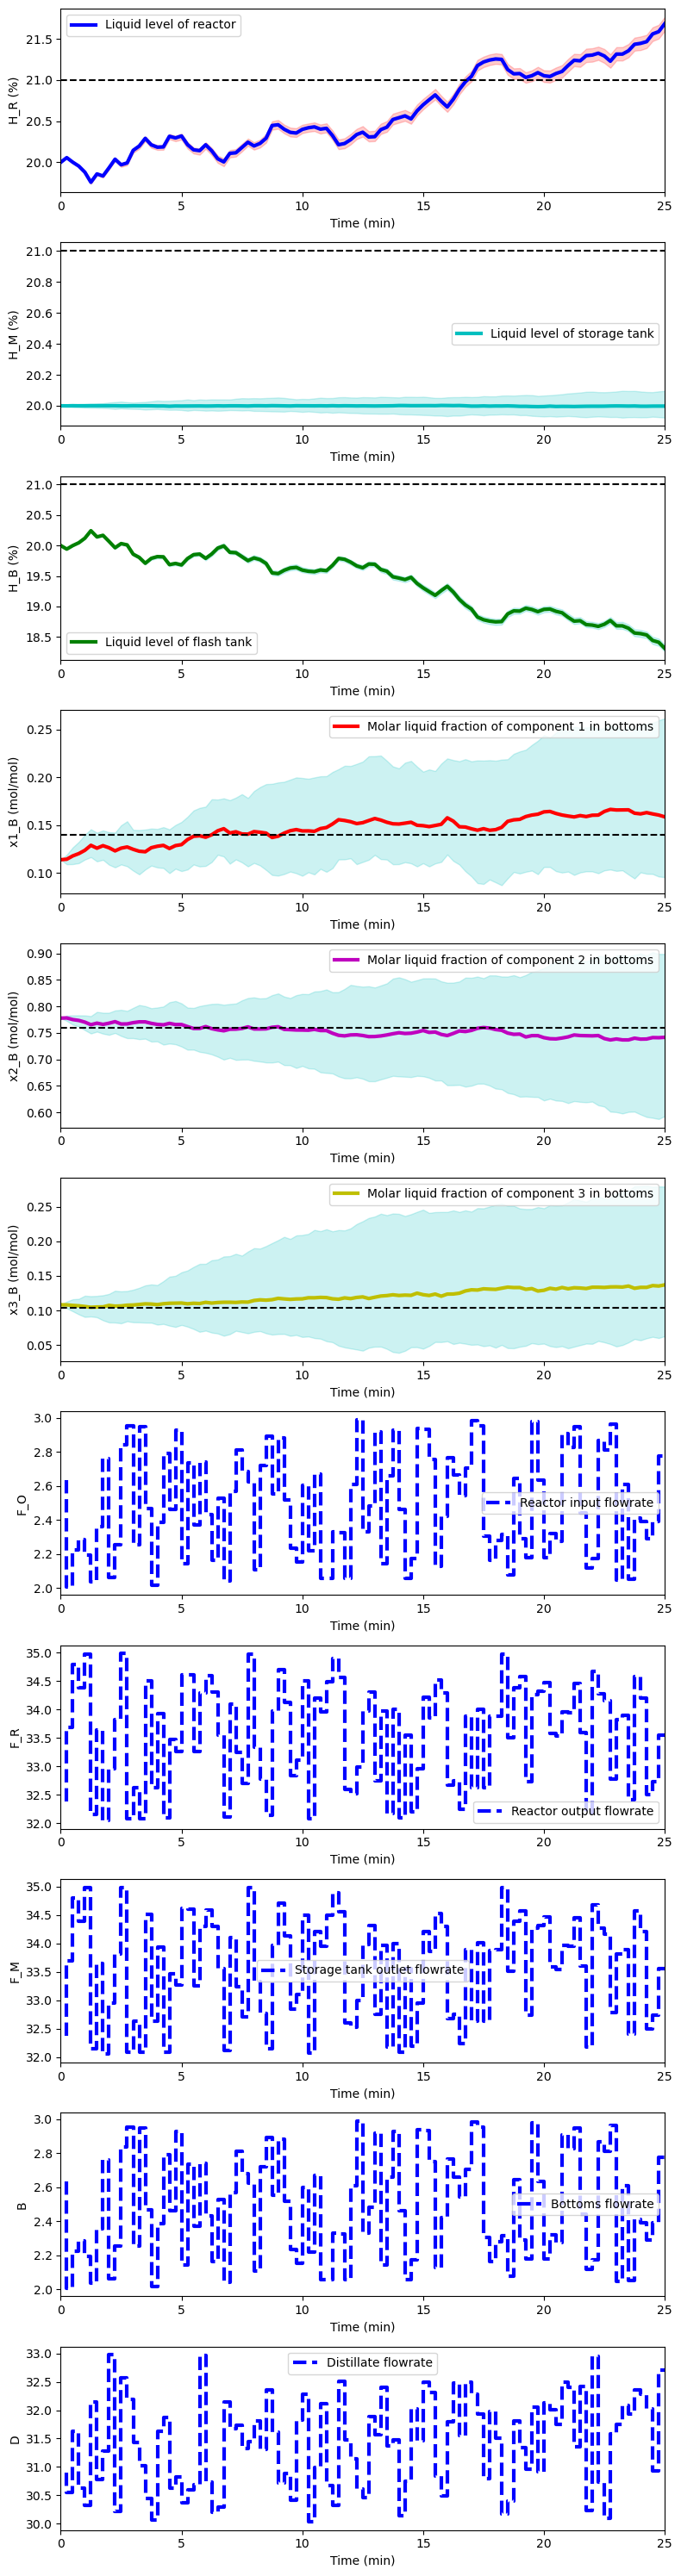

In [28]:
# Step cooling temperature to 295
u_example = np.zeros((5, n-1))
for i in range(n-1):
    u_example[0, i] = np.random.uniform(low=2, high=3)
    u_example[1, i] = np.random.uniform(low=32, high=35)
    u_example[2, i] = u_example[1, i]
    u_example[3, i] = u_example[0, i]
    u_example[4, i] = np.random.uniform(low=30, high=33)

n_1 = int(n/5)
n_2 = int(n/5)
n_3 = int(n/5)
n_4 = int(n/5)
n_5 = n - n_1 - n_2 - n_3 - n_4 - 1

#u_example[0, :] = [3 for i in range(n_1)] + [1.667 for i in range(n_2)] + [1.667 for i in range(n_3)] + [1.667 for i in range(n_4)] + [1.667 for i in range(n_5)]
#u_example[1, :] = [31.33 for i in range(n_1)] + [35 for i in range(n_2)] + [31.33 for i in range(n_3)] + [31.33 for i in range(n_4)] + [31.33 for i in range(n_5)]
#u_example[2, :] = [31.33 for i in range(n_1)] + [31.33 for i in range(n_2)] + [35 for i in range(n_3)] + [31.33 for i in range(n_4)] + [31.33 for i in range(n_5)]
#u_example[3, :] = [1.667 for i in range(n_1)] + [1.667 for i in range(n_2)] + [1.667 for i in range(n_3)] + [3 for i in range(n_4)] + [1.667 for i in range(n_5)]
#u_example[4, :] = [29.67 for i in range(n_1)] + [29.67 for i in range(n_2)] + [29.67 for i in range(n_3)] + [29.67 for i in range(n_4)] + [33 for i in range(n_5)]

#u_example[0, :] = [2.5 for i in range(n_1)] + [2.5 for i in range(n_2)] + [2.5 for i in range(n_3)] + [2.5 for i in range(n_4)] + [2.5 for i in range(n_5)]
#u_example[1, :] = [35 for i in range(n_1)] + [35 for i in range(n_2)] + [35 for i in range(n_3)] + [35 for i in range(n_4)] + [35 for i in range(n_5)]
#u_example[2, :] = [35 for i in range(n_1)] + [35 for i in range(n_2)] + [35 for i in range(n_3)] + [35 for i in range(n_4)] + [35 for i in range(n_5)]
#u_example[3, :] = [2.5 for i in range(n_1)] + [2.5 for i in range(n_2)] + [2.5 for i in range(n_3)] + [2.5 for i in range(n_4)] + [2.5 for i in range(n_5)]
#u_example[4, :] = [33 for i in range(n_1)] + [33 for i in range(n_2)] + [33 for i in range(n_3)] + [33 for i in range(n_4)] + [33 for i in range(n_5)]


# Simulation
H_R_dat, x1_R_dat, x2_R_dat, x3_R_dat, H_M_dat, x1_M_dat, x2_M_dat, x3_M_dat, H_B_dat, x1_B_dat, x2_B_dat, x3_B_dat, F_O_dat, F_R_dat, F_M_dat, B_dat, D_dat = simulate_PLANT(u_example, data_res, 100)
# print(H_R_dat)

means = [21.5, 19.5, 19.5, 0.14, 0.76, 0.104, 0, 0, 0, 0, 0, 0] # sp states, sp errors
ranges = [2, 0.6, 2, 0.06, 0.05, 0.01, 2, 0.6, 2, 0.06, 0.05, 0.01] # sp states, sp errors

#means = [np.mean(np.mean(X1_dat, axis=1),axis=0), np.mean(np.mean(Y1_dat, axis=1),axis=0), np.mean(np.mean(X2_dat, axis=1),axis=0), np.mean(np.mean(Y2_dat, axis=1),axis=0), np.mean(np.mean(X3_dat, axis=1),axis=0), np.mean(np.mean(Y3_dat, axis=1),axis=0), np.mean(np.mean(X4_dat, axis=1),axis=0), np.mean(np.mean(Y4_dat, axis=1),axis=0), np.mean(np.mean(X5_dat, axis=1),axis=0), np.mean(np.mean(Y5_dat, axis=1),axis=0)]
#ranges = [np.max(np.max(X1_dat, axis=0)-np.min(X1_dat, axis=0)), np.max(np.max(Y1_dat, axis=0)-np.min(Y1_dat, axis=0)),np.max(np.max(X2_dat, axis=0)-np.min(X2_dat, axis=0)), np.max(np.max(Y2_dat, axis=0)-np.min(Y2_dat, axis=0)), np.max(np.max(X3_dat, axis=0)-np.min(X3_dat, axis=0)), np.max(np.max(Y3_dat, axis=0)-np.min(Y3_dat, axis=0)), np.max(np.max(X4_dat, axis=0)-np.min(X4_dat, axis=0)), np.max(np.max(Y4_dat, axis=0)-np.min(Y4_dat, axis=0)), np.max(np.max(X5_dat, axis=0)-np.min(X5_dat, axis=0)), np.max(np.max(Y5_dat, axis=0)-np.min(Y5_dat, axis=0))]
#print(means)
#print(ranges)
# Plot the results
plot_simulation(H_R_dat, H_M_dat, H_B_dat, x1_B_dat, x2_B_dat, x3_B_dat, data_res)

We normalize the inputs and states

In [29]:
# normalization for states and actions
data_res['x_norm'] = np.array([means, ranges]) # [mean],[range]
data_res['u_norm'] = np.array([[1.4/6, 3.5/6, 3.5/6, 1.4/6, 3.5/6],[1.6, 31.5, 31.5, 1.6, 29.5]])    # [range/6],[bias]

Now, let's create the objective function for the policy network. 

```{tip} Notice the difference between this objective function and the objective function use in [tutorial 6](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html). We have included a conditional to switch between algorithms.
```


In [44]:
def J_PolicyPLANT(policy, data_res=data_res, policy_alg='PID', 
                 collect_training_data=True, traj=False, episode=False):
    
    # load data
    
    # states
    H_R     = copy.deepcopy(data_res['H_R_dat'])
    x1_R    = copy.deepcopy(data_res['x1_R_dat'])
    x2_R    = copy.deepcopy(data_res['x2_R_dat'])
    x3_R    = copy.deepcopy(data_res['x3_R_dat'])
    H_M     = copy.deepcopy(data_res['H_M_dat'])
    x1_M    = copy.deepcopy(data_res['x1_M_dat'])
    x2_M    = copy.deepcopy(data_res['x2_M_dat'])
    x3_M    = copy.deepcopy(data_res['x3_M_dat'])
    H_B     = copy.deepcopy(data_res['H_B_dat'])
    x1_B    = copy.deepcopy(data_res['x1_B_dat'])
    x2_B    = copy.deepcopy(data_res['x2_B_dat'])
    x3_B    = copy.deepcopy(data_res['x3_B_dat'])
    
    # actions
    F_O     = copy.deepcopy(data_res['F_O_dat'])
    F_R     = copy.deepcopy(data_res['F_R_dat'])
    F_M     = copy.deepcopy(data_res['F_M_dat'])
    B       = copy.deepcopy(data_res['B_dat'])
    D       = copy.deepcopy(data_res['D_dat'])
    
    t       = copy.deepcopy(data_res['t']) 
    x0      = copy.deepcopy(data_res['x0'])
    noise   = data_res['noise']
    

    # setpoints      
    H_R_des = data_res['H_R_des'] 
    H_M_des = data_res['H_M_des']
    H_B_des = data_res['H_B_des']
    x1_B_des = data_res['x1_B_des']
    x2_B_des = data_res['x2_B_des']
    x3_B_des = data_res['x3_B_des']
    
    # upper and lower bounds
    F_O_ub  = data_res['F_O_ub'];  F_O_lb  = data_res['F_O_lb']
    F_R_ub  = data_res['F_R_ub'];  F_R_lb  = data_res['F_R_lb']
    F_M_ub  = data_res['F_M_ub'];  F_M_lb  = data_res['F_M_lb']
    B_ub  = data_res['B_ub'];  B_lb  = data_res['B_lb']
    D_ub  = data_res['D_ub'];  D_lb  = data_res['D_lb']
    
    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = copy.deepcopy(data_res['x0'])
    e_history = []

    # log probs
    if policy_alg == 'PG_RL':
      log_probs = [None for i in range(len(t)-1)]
    
    # Simulate column
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([H_R_des[i], H_M_des[i], H_B_des[i], x1_B_des[i], x2_B_des[i], x3_B_des[i]]) # since we only care about controlling the first and last variables, set the s.p. of the others equal to the process variable
        ctrl_x  = np.array([x[0], x[4], x[8], x[9], x[10], x[11]])
        #### PID ####
        if policy_alg == 'PID':
          if i == 0:
            Tc[i] = PID(policy, x, x_sp, np.array([[0,0]]))
          else:
            Tc[i] = PID(policy, x, x_sp, np.array(e_history))

        # --------------> New compared to tutorial 6 <-------------------
        #### Stochastic Policy Search ####
        elif policy_alg == 'SPS_RL':
          xk      = np.hstack((ctrl_x,x_sp-ctrl_x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = torch.tensor(xknorm)
          # compute u_k from policy
          # print('normalised state',xknorm)
          mean_uk      = policy(xknorm_torch).detach().numpy()
          u_k          = np.reshape(mean_uk, (1, 5))
          u_k          = u_k*u_norm[0] + u_norm[1]
          #print("The first value for u_k is:", u_k)
          u_k          = u_k[0]
          #print("The second value for u_k is:", u_k)
          u_k[0]       = min(max(u_k[0], F_O_lb), F_O_ub)
          u_k[1]       = min(max(u_k[1], F_R_lb), F_R_ub)
          u_k[2]       = min(max(u_k[2], F_M_lb), F_M_ub)
          u_k[3]       = min(max(u_k[3], B_lb), B_ub)
          u_k[4]       = min(max(u_k[4], D_lb), D_ub) 
          #print("The third value for u_k is:", u_k)
          F_O[i]         = u_k[0]
          F_R[i]         = u_k[1]
          F_M[i]         = u_k[2]
          B[i]           = u_k[3]
          D[i]           = u_k[4]
          eqn_inputs     = (F_O[i], F_R[i], F_M[i], B[i], D[i])
          
          

        #### Policy Gradients #### 
        # See next section for the explanation on Policy gradients!
        elif policy_alg == 'PG_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = Tensor(xknorm)
          # compute u_k distribution
          m, s                      = policy(xknorm_torch)[0,0]
          s                         = s + eps
          mean_uk, std_uk           = mean_std(m, s)
          u_k, logprob_k, entropy_k = select_action(mean_uk, std_uk)
          u_k                       = np.reshape(u_k.numpy(), (nu))
          # hard bounds on inputs
          u_k                       = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]                     = u_k
          log_probs[i] = logprob_k
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(large_scale_ode,x,ts,args=(eqn_inputs,))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=12)
        H_R[i+1]       = max(min((y[-1][0] + noise*s[0]*0.1), 100), 0)   
        x1_R[i+1]      = max(min((y[-1][1] + noise*s[1]*0.1), 1), 0) 
        x2_R[i+1]      = max(min((y[-1][2] + noise*s[2]*0.1), 1), 0) 
        x3_R[i+1]      = max(min((y[-1][3] + noise*s[3]*0.1), 1), 0) 
        H_M[i+1]       = max(min((y[-1][4] + noise*s[4]*0.1), 100), 0) 
        x1_M[i+1]      = max(min((y[-1][5] + noise*s[5]*0.1), 1), 0) 
        x2_M[i+1]      = max(min((y[-1][6] + noise*s[6]*0.1), 1), 0) 
        x3_M[i+1]      = max(min((y[-1][7] + noise*s[7]*0.1), 1), 0) 
        H_B[i+1]       = max(min((y[-1][8] + noise*s[8]*0.1), 100), 0)
        x1_B[i+1]      = max(min((y[-1][9] + noise*s[9]*0.1), 1), 0)
        x2_B[i+1]      = max(min((y[-1][10] + noise*s[10]*0.1), 1), 0)
        x3_B[i+1]      = max(min((y[-1][11] + noise*s[11]*0.1), 1), 0)
        # state update
        x[0]         = H_R[i+1]
        x[1]         = x1_R[i+1]
        x[2]         = x2_R[i+1]
        x[3]         = x3_R[i+1]
        x[4]         = H_M[i+1]
        x[5]         = x1_M[i+1]
        x[6]         = x2_M[i+1]
        x[7]         = x3_M[i+1]
        x[8]         = H_B[i+1]
        x[9]         = x1_B[i+1]
        x[10]         = x2_B[i+1]
        x[11]         = x3_B[i+1]
        # compute tracking error
        ctrl_x = np.array([x[0], x[4], x[8], x[9], x[10], x[11]])
        e_history.append((x_sp-ctrl_x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/ranges[0]+np.abs(np.array(e_history)[:,1])/ranges[1]+np.abs(np.array(e_history)[:,2])/ranges[2]+np.abs(np.array(e_history)[:,3])/ranges[3]+np.abs(np.array(e_history)[:,4])/ranges[4]
    # penalize magnitude of control action
    u_mag = np.abs(F_O[:]-F_O_lb)/50+np.abs(F_R[:]-F_R_lb)/100+np.abs(F_M[:]-F_M_lb)/100+np.abs(B[:]-B_lb)/50+np.abs(D[:]-D_lb)/100
    u_mag = u_mag*0 # min 50
    # penalize change in control action
    u_cha = np.abs(F_O[1:]-F_O[0:-1])/50+np.abs(F_R[1:]-F_R[0:-1])/50+np.abs(F_M[1:]-F_M[0:-1])/50+np.abs(B[1:]-B[0:-1])/50+np.abs(D[1:]-D[0:-1])/50
    u_cha = u_cha*0 # min 10 
    
    # collect data for plots
    if collect_training_data:
        data_res['H_R_train'].append(H_R)
        data_res['x1_R_train'].append(x1_R)
        data_res['x2_R_train'].append(x2_R)
        data_res['x3_R_train'].append(x3_R)
        data_res['H_M_train'].append(H_M)
        data_res['x1_M_train'].append(x1_M)
        data_res['x2_M_train'].append(x2_M)
        data_res['x3_M_train'].append(x3_M)
        data_res['H_B_train'].append(H_B)
        data_res['x1_B_train'].append(x1_B)
        data_res['x2_B_train'].append(x2_B)
        data_res['x3_B_train'].append(x3_B)
        
        data_res['F_O_train'].append(F_O)
        data_res['F_R_train'].append(F_R)
        data_res['F_M_train'].append(F_M)
        data_res['B_train'].append(B)
        data_res['D_train'].append(D)
        
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if episode:
      # See next section for the explanation on Policy gradients!
      sum_logprob = sum(log_probs)
      reward      = -(error + u_mag + u_cha)
      return reward, sum_logprob
    
    if traj:
      return H_R, H_M, H_B, x1_B, x2_B, x3_B, F_O, F_R, F_M, B, D
    else:
      return error + u_mag + u_cha # u_mag is the culprit now


As mentioned above, we are going to use a stochastic search algorithm that combines random search with local random search to optimize the policy network.

The code below has two main elements:

**Random Search Step**: During this step neural network weights are sampled uniformely (given some bounds). Each set of parameters is evaluated (a simulation is run), and the parameter set that performed best is passed to the next step.

An illustration of how Random Search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/random_search.PNG
:alt: kNN
:width: 75%
:align: center

An illustration of the random search algorithm. [source](https://commons.wikimedia.org/wiki/File:Hyperparameter_Optimization_using_Random_Search.svg)
```

**Local Search Step**: This step starts from the best parameter values found by the *Random Search Step*. Subsequently it does a random search close by the best value found (hence termed stocastic local search). Additionally, if after some number of interations a better function value has not been found (also via simulating the system), the radius of search is reduced. 

An illustration of how Local search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/local_random_search.PNG
:alt: kNN
:width: 70%
:align: center

An illustration of the local search algorithm.
```

By combining a 'global search' strategy (Random search) and a 'local search' strategy (Local search) we balance exploration and exploitation which is a key concept in reinforcement learning.

In [32]:
#######################
# auxiliary functions #
#######################

def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params

def extract_NN_values(list_of_params):
    rows_tensors = []
    for params_dict in list_of_params:
        layer_shapes = []
        list_tensors = []
        layer_sizes = []
        for tensor in params_dict.values():
            list_tensors.append(torch.flatten(tensor))
            layer_sizes.append(torch.numel(tensor))
            layer_shapes.append(tensor.size())
        row_tensors = torch.cat(list_tensors)
        rows_tensors.append(row_tensors)
    mat_tensors = torch.stack(rows_tensors)
    return mat_tensors, layer_sizes, layer_shapes
    
def convert_to_NN_dict(tensor, layer_sizes, layer_shapes, params):
    split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
    NN_values = torch.tensor_split(tensor.squeeze(), split_indices, dim=0)
    NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    dict_names = list(params.keys())
    dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
    return dict_params
    


###################
# Genetic Algorithm
###################
    
def GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.1, iterations=12, sample_size=10):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise population
    population = []
    
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_uniform_params(params, lower_bound, upper_bound)
        population.append(copy.deepcopy(member))
        
    #print("Population before:", population)
        
    for i in range(iterations+1):
        pop_tensor, layer_sizes, layer_shapes = extract_NN_values(population)
        fun_population = []
        print("Iteration", i)
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_index = fitness_scores.index(max(fitness_scores))
        best_guess = pop_tensor[best_index, :]
        new_generation = [best_guess] # it automatically becomes part of the new generation
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (index1, index2) = random.choices(list(range(len(selection_probs))), selection_probs, k=2) # select two parents
            parent1 = pop_tensor[index1, :]
            parent2 = pop_tensor[index2, :]
            children = []
            index = random.randint(1, parent1.shape[0])
            child1 = torch.cat([parent1[0:index], parent2[index:]])
            child2 = torch.cat([parent2[0:index], parent1[index:]])
            children.append(child1) # do crossover of parent guesses to form children
            children.append(child2)
            for child in children:
                child[(random.random() < mutation_rate)] = np.random.uniform(lower_bound, upper_bound)
            new_generation.extend(children)
        population = [convert_to_NN_dict(member, layer_sizes, layer_shapes, params) for member in new_generation]
        stop = time.time()
        iter_time = stop - start
        time_axis.append(iter_time)
        gbest_history.append(min(fun_population))
        
    fun_population = []
    for j in range(len(population)):
        current_params = population[j] # fetch current NN parameter set
        policy_net.load_state_dict(current_params) # load set into NN
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                            policy_alg='SPS_RL') # evaluate NN in the controller simulation
        fun_population.append(reward) # add reward to the corresponding list
        
    best_policy = population[fun_population.index(min(fun_population))]
    best_reward = min(fun_population)
    
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward, gbest_history, time_axis

##########################
# Particle swarm algorithm
##########################

def ParticleSwarm(lower_bound, upper_bound, no_particles, inertia, cognitive, social, regime, tmax):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 10
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise empty particle and velocity lists
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    #print("Initial tensors:", dict_particles[0]) 
    # extract the neural network parameters only, turn them into a 2-d matrix: rows = particles, columns = NN weights
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    #print(particles)
    #print(layer_sizes)
    #print(particles)
    
    pbest = copy.deepcopy(particles)
    r_pbest = []

    for p in dict_particles:
        policy_net.load_state_dict(p)
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        r_pbest.append(reward)
    r_pbest = np.array(r_pbest)
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    for t in range(tmax+1):
        print("Iteration", t)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            #print("NN set:", nn_set)
            NN_values = torch.tensor_split(nn_set, split_indices, dim=1)
            # NN_values_T = [nn.transpose() for nn in NN_values]
            NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
            #print("Reshaped tensors:", NN_values_reshaped)
            #print("NN values:", NN_values)
            dict_names = list(params.keys())
            dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)  
    
    end = time.time()
    end_time = end - start


    gbest_values = torch.tensor_split(gbest, split_indices, dim=0)
    gbest_layers = [torch.reshape(gbest_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    best_policy = {dict_names[i]: gbest_layers[i] for i in range(len(dict_names))}
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return best_policy, r_gbest, gbest_history, time_axis


#######################
# Artificial Bee Colony
#######################
def ArtificialBeeColony(lower_bound, upper_bound, no_employed, no_onlooker, distance_value, iterations, scout_limit):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    dict_bees = [sample_uniform_params(params, lower_bound, upper_bound) for bee in range(no_employed)]
    bee_values, layer_sizes, layer_shapes = extract_NN_values(dict_bees)
    employed_bees = [{'solution': bee_values[i], 'fitness': None, 'trials': 0, 'reward': None} for i in range(len(bee_values))]
    best_reward = 1e8

    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for bee in employed_bees:
            second_bee = np.random.randint(0, no_employed)
            distance = np.random.uniform(-distance_value, distance_value)
            new_solution = bee['solution'] + distance*(bee['solution'] - employed_bees[second_bee]['solution'])
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if bee['reward'] == None or reward < bee['reward']:
                bee['solution'] = new_solution
                bee['reward'] = reward
                bee['fitness'] = fitness
                bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        total_fitness = np.sum([bee['fitness'] for bee in employed_bees])
        selection_probs = []
        for bee in employed_bees:
            selection_probs.append(bee['fitness'] / total_fitness)
            
        for onlooker in range(no_onlooker):
            onlooker_bee_list = random.choices(employed_bees, selection_probs, k=1)
            onlooker_bee = onlooker_bee_list[0]
            second_bee_index = np.random.randint(0, no_employed)
            second_bee = employed_bees[second_bee_index]
            distance = np.random.uniform(-distance_value, distance_value)
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if reward < onlooker_bee['reward']:
                onlooker_bee['solution'] = new_solution
                onlooker_bee['reward'] = reward
                onlooker_bee['fitness'] = fitness
                onlooker_bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        for bee in employed_bees:
            if bee['trials'] >= scout_limit and bee['reward'] != best_reward:
                rand_soln = sample_uniform_params(params, lower_bound, upper_bound)
                new_soln, layer_sizes, layer_shapes = extract_NN_values([rand_soln])
                bee['solution'] = new_soln[0]
                dict_params = convert_to_NN_dict(bee['solution'], layer_sizes, layer_shapes, params)
                policy_net.load_state_dict(dict_params)
                bee['reward'] = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                bee['fitness'] = 1/bee['reward']
                bee['trials'] = 0
            
        best_bee = min(employed_bees, key=lambda bee: bee['reward'])
        best_policy = convert_to_NN_dict(best_bee['solution'], layer_sizes, layer_shapes, params)
        best_reward = best_bee['reward']
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)  
    

    end = time.time()
    end_time = end - start

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis
    
#####################
# Simulated Annealing
#####################

def SimulatedAnnealing(lower_bound, upper_bound, initial_accept_prob, max_iterations, step_size, temp_regime):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    probabilities = []
    temperatures = []
    function_counter = 1
    
    startpoint = sample_uniform_params(params, lower_bound, upper_bound)
    policy_net.load_state_dict(startpoint)
    reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    best_policy = startpoint
    best_reward = reward
    
    policy_tensor, layer_sizes, layer_shapes = extract_NN_values([startpoint])
    policy_tensor = policy_tensor[0]
    new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*2*step_size)
    dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
    policy_net.load_state_dict(dict_params)
    new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    functiondiff = new_reward - best_reward
    deltafunction = np.abs(functiondiff.copy())
    function_counter += 1
    
    # Use deltafunction to calculate an initial temperature
    max_temp = -deltafunction/(np.log(initial_accept_prob))
    temperature = max_temp.copy()
    
     # Condition if the new guess is better
    if functiondiff < 0:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward.copy()
        
    # Condition if the new guess is worse
    randomguess = random.random()
    if randomguess < initial_accept_prob:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward
        
    if temp_regime == 'log':    
        temperature = max_temp.copy() / np.log(function_counter)
    if temp_regime == 'reciprocal':
        temperature = max_temp.copy() / (function_counter)
    if temp_regime == 'exp':
        temperature = max_temp.copy() * 0.8**(function_counter)
        
    for i in range(max_iterations):
        print("Iteration", i+1)
        policy_tensor, layer_sizes, layer_shapes = extract_NN_values([best_policy])
        policy_tensor = policy_tensor[0]
        new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*step_size)
        dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
        policy_net.load_state_dict(dict_params)
        new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        function_counter += 1
        
        functiondiff = new_reward - best_reward
        deltafunction = np.abs(functiondiff.copy())
        acceptanceprob = np.exp(-deltafunction.copy()/temperature.copy())
        function_counter += 1
    
         # Condition if the new guess is better
        if functiondiff < 0:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward.copy()
        
        # Condition if the new guess is worse
        randomguess = random.random()
        if randomguess < acceptanceprob:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward
        
        if temp_regime == 'log':    
            temperature = max_temp.copy() / np.log(function_counter)
        if temp_regime == 'reciprocal':
            temperature = max_temp.copy() / (function_counter)
        if temp_regime == 'exp':
            temperature = max_temp.copy() * 0.95**(function_counter)
            
        probabilities.append(acceptanceprob)
        temperatures.append(temperature)

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 

    end = time.time()
    end_time = end - start
        
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis

###################
# Firefly Algorithm
###################
def Firefly(lower_bound, upper_bound, no_fireflies, iterations, attractiveness, randomness, absorption):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    fireflies = [sample_uniform_params(params, lower_bound, upper_bound) for firefly in range(no_fireflies)]
    rewards = []
    
    for firefly in fireflies:
        policy_net.load_state_dict(firefly)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
    rewards = np.array(rewards)
    light_int = 1/rewards
    
    fireflies_tensor, layer_sizes, layer_shapes = extract_NN_values(fireflies)
    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for i in range(no_fireflies):
            for j in range(i):
                if light_int[j] > light_int[i]:
                    distance = fireflies_tensor[j, :] - fireflies_tensor[i, :]
                    r = torch.linalg.norm(distance)
                    fireflies_tensor[i, :] += (attractiveness*np.exp(-absorption*r**2)*distance + randomness*torch.rand(distance.shape))
                    NN_sets = torch.tensor_split(fireflies_tensor, no_fireflies, dim=0)
                    for nn_set in NN_sets:
                        dict_params = convert_to_NN_dict(nn_set, layer_sizes, layer_shapes, params)
                        policy_net.load_state_dict(dict_params)
                        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                        rewards[i] = reward
                        light_int[i] = 1/reward
        best_guess = fireflies_tensor[rewards.argmin(), :]
        best_reward = rewards.min()

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 
                                        
    end = time.time()
    end_time = end - start
    
    best_policy = convert_to_NN_dict(best_guess, layer_sizes, layer_shapes, params) 

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
                                        
    return best_policy, best_reward, gbest_history, time_axis




########################
# Differential Evolution
########################

def DifferentialEvolution(lower_bound, upper_bound, iterations, pop_size, cr, f):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    
    # initialise population and rewards
    population = [sample_uniform_params(params, lower_bound, upper_bound) for agent in range(pop_size)]
    pop_tensors, layer_sizes, layer_shapes = extract_NN_values(population)
    rewards = []
    
    for agent in population:
        policy_net.load_state_dict(agent)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
        
    # convert rewards to numpy array for later handling
    rewards = np.array(rewards)
    
    # initialise main algorithm loop
    for i in range(iterations):
        print("Iteration", i)
        for a in range(pop_size):
            agent_list = list(range(pop_size)) # initialise a list of agent indices to edit as agents are selected
            print(agent_list)
            agent = pop_tensors[a, :] # iterate through each agent in the pulation
            agent_list.remove(a)
            agent_indices = random.choices(agent_list, k=3) # select indices of the other 3 agents
            new_agents = [pop_tensors[index, :] for index in agent_indices] # fetch information about 3 agents
            random_index = random.randint(0, sum(layer_sizes)-1) # select a random index
            crossover_probs = torch.rand(agent.shape)
            # re-calculate the randomly selected index AND a random selection of other coords with probability cr
            agent[random_index or (crossover_probs < cr)] = new_agents[0][random_index or (crossover_probs < cr)] + f*(new_agents[1][random_index or (crossover_probs < cr)] - new_agents[2][random_index or (crossover_probs < cr)]) 
            dict_params = convert_to_NN_dict(agent, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            if rewards[a] < reward:
                pop_tensors[a, :] = agent
                rewards[a] = reward
        best_agent = pop_tensors[rewards.argmin(), :]
        gbest_history.append(rewards.min())
        stop = time.time()
        timestamp = stop - start
        time_axis.append(timestamp)
        
    best_policy = convert_to_NN_dict(best_agent, layer_sizes, layer_shapes, params)
    best_reward = rewards.min()
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
            
            
    return best_policy, best_reward, gbest_history, time_axis
    


#################################
# Generalized policy search 
#################################

def Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=1, 
                              evals=12, ratio_ls_rs=0.3):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''
    start = time.time()

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem initialisation
    nu        = 5
    nx        = 6
    hyparams  = {'input_size': nx+6, 'output_size': nu} # include setpoints +6
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 1# 1.5
    param_min  = -1#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []
    
    
    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        print("Iteration", policy_i)
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyPLANT(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)   
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)      

            
    
    ###############
    # local search
    ###############

    # define max radius
    r0    = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:
        print("Iteration", iter_i)

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        reward = J_PolicyPLANT(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') 

        # choose the == Min == value      
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1 

        # save best reward
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)   

        end = time.time()
        end_time = end - start

    print('final reward = ',best_reward)
    print('radius = ',radius)
    print('time = ',end_time)
    return best_policy, best_reward, gbest_history, time_axis


In [1]:
#################################
# Generalized policy search 
#################################

def Random_PSO_search(lower_bound, upper_bound, evals_rs, evals_pso, no_particles, inertia, cognitive, social):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''
    start = time.time()

    # problem initialisation
    nu        = 2
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = lower_bound# 1.5
    param_min  = upper_bound#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []
    
    # == initialise particles == #
    
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    
    # convert particles into PyTorch tensors
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    
    pbest = copy.deepcopy(particles)
    r_pbest = np.zeros((no_particles,))
    
    
    ################################
    # Random search on each particle
    ################################
    for e in range(evals_rs):
        print("Iteration", e)
        for i in range(no_particles):
            # == Random Search in policy == #
            # sample a random policy
            NNparams_RS  = sample_uniform_params(params, param_max, param_min)
            # consrict policy to be evaluated
            policy_net.load_state_dict(NNparams_RS)
            # evaluate policy
            new_reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            current_p = particles[i, :]
            dict_current_p = convert_to_NN_dict(current_p, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_current_p)
            current_reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            # benchmark reward ==> min "<"
            if new_reward < current_reward:
                pbest[i, :], _, __ = extract_NN_values(NNparams_RS)
                r_pbest[i] = new_reward
        
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)
        
    ##################
    # PSO search phase
    ##################
    
    for e in range(evals_pso):
        print("Iteration", e + evals_rs)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            #print("NN set:", nn_set)
            NN_values = torch.tensor_split(nn_set, split_indices, dim=1)
            # NN_values_T = [nn.transpose() for nn in NN_values]
            NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
            #print("Reshaped tensors:", NN_values_reshaped)
            #print("NN values:", NN_values)
            dict_names = list(params.keys())
            dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest) 
        
        
    gbest_values = torch.tensor_split(gbest, split_indices, dim=0)
    gbest_layers = [torch.reshape(gbest_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    best_policy = {dict_names[i]: gbest_layers[i] for i in range(len(dict_names))}
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return best_policy, r_gbest, gbest_history, time_axis
        
            

In [40]:
# data for plots
data_res['H_R_train']    = []; data_res['x1_R_train']     = []; data_res['x2_R_train']    = []; data_res['x3_R_train']     = []
data_res['H_M_train']    = []; data_res['x1_M_train']     = []; data_res['x2_M_train']    = []; data_res['x3_M_train']     = []
data_res['H_B_train']    = []; data_res['x1_B_train']     = []; data_res['x2_B_train']    = []; data_res['x3_B_train']     = []

data_res['F_O_train']    = [] 
data_res['F_R_train']    = []
data_res['F_M_train']    = []
data_res['B_train']      = []
data_res['D_train']      = []

data_res['err_train']   = []
data_res['u_mag_train'] = [] 
data_res['u_cha_train'] = []

# problem parameters
e_tot = 5000
e_shr = e_tot/30

# Policy optimization
best_policy, best_reward, gbest_history, time_axis = Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=e_shr, evals=e_tot, ratio_ls_rs=0.3)
# best_policy, best_reward, gbest_history, time_axis = GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.35, iterations=50, sample_size=25)
# best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-1, upper_bound=1, no_particles=50, inertia=0.6, cognitive=0.36, social=0.04, regime=None, tmax=100)
# best_policy, best_reward, gbest_history, time_axis = ArtificialBeeColony(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=25, distance_value=1, iterations=e_tot, scout_limit=2)
# best_policy, best_reward, gbest_history, time_axis = SimulatedAnnealing(lower_bound=-5, upper_bound=5, initial_accept_prob=0.4, max_iterations=e_tot, step_size=0.4, temp_regime='exp')
# best_policy, best_reward, gbest_history, time_axis = Firefly(lower_bound=-5, upper_bound=5, no_fireflies=10, iterations=e_tot, attractiveness=0.8, absorption=0, randomness=0.2)
# best_policy, best_reward, gbest_history, time_axis = DifferentialEvolution(lower_bound=-5, upper_bound=5, iterations=50, pop_size=10, cr=0.9, f=0.8)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7


C:\Users\ip120\AppData\Local\Temp\ipykernel_1756\4050935508.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  (1/(rho*A_B*H_B))*(F_M*(x1_M-x1_B) - D*(x1_D - x1_B)),
C:\Users\ip120\AppData\Local\Temp\ipykernel_1756\4050935508.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  (1/(rho*A_B*H_B))*(F_M*(x2_M-x2_B) - D*(x2_D - x2_B)),
C:\Users\ip120\AppData\Local\Temp\ipykernel_1756\4050935508.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  (1/(rho*A_B*H_B))*(F_M*(x3_M-x3_B) + D*(x3_B))


Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iteration 79
Iteration 80
Iteration 81
Iteration 82
Iteration 83
Iteration 84
I

Iteration 601
Iteration 602
Iteration 603
Iteration 604
Iteration 605
Iteration 606
Iteration 607
Iteration 608
Iteration 609
Iteration 610
Iteration 611
Iteration 612
Iteration 613
Iteration 614
Iteration 615
Iteration 616
Iteration 617
Iteration 618
Iteration 619
Iteration 620
Iteration 621
Iteration 622
Iteration 623
Iteration 624
Iteration 625
Iteration 626
Iteration 627
Iteration 628
Iteration 629
Iteration 630
Iteration 631
Iteration 632
Iteration 633
Iteration 634
Iteration 635
Iteration 636
Iteration 637
Iteration 638
Iteration 639
Iteration 640
Iteration 641
Iteration 642
Iteration 643
Iteration 644
Iteration 645
Iteration 646
Iteration 647
Iteration 648
Iteration 649
Iteration 650
Iteration 651
Iteration 652
Iteration 653
Iteration 654
Iteration 655
Iteration 656
Iteration 657
Iteration 658
Iteration 659
Iteration 660
Iteration 661
Iteration 662
Iteration 663
Iteration 664
Iteration 665
Iteration 666
Iteration 667
Iteration 668
Iteration 669
Iteration 670
Iteration 671
Iterat

Iteration 1174
Iteration 1175
Iteration 1176
Iteration 1177
Iteration 1178
Iteration 1179
Iteration 1180
Iteration 1181
Iteration 1182
Iteration 1183
Iteration 1184
Iteration 1185
Iteration 1186
Iteration 1187
Iteration 1188
Iteration 1189
Iteration 1190
Iteration 1191
Iteration 1192
Iteration 1193
Iteration 1194
Iteration 1195
Iteration 1196
Iteration 1197
Iteration 1198
Iteration 1199
Iteration 1200
Iteration 1201
Iteration 1202
Iteration 1203
Iteration 1204
Iteration 1205
Iteration 1206
Iteration 1207
Iteration 1208
Iteration 1209
Iteration 1210
Iteration 1211
Iteration 1212
Iteration 1213
Iteration 1214
Iteration 1215
Iteration 1216
Iteration 1217
Iteration 1218
Iteration 1219
Iteration 1220
Iteration 1221
Iteration 1222
Iteration 1223
Iteration 1224
Iteration 1225
Iteration 1226
Iteration 1227
Iteration 1228
Iteration 1229
Iteration 1230
Iteration 1231
Iteration 1232
Iteration 1233
Iteration 1234
Iteration 1235
Iteration 1236
Iteration 1237
Iteration 1238
Iteration 1239
Iteration 

Iteration 245
Iteration 246
Iteration 247
Iteration 248
Iteration 249
Iteration 250
Iteration 251
Iteration 252
Iteration 253
Iteration 254
Iteration 255
Iteration 256
Iteration 257
Iteration 258
Iteration 259
Iteration 260
Iteration 261
Iteration 262
Iteration 263
Iteration 264
Iteration 265
Iteration 266
Iteration 267
Iteration 268
Iteration 269
Iteration 270
Iteration 271
Iteration 272
Iteration 273
Iteration 274
Iteration 275
Iteration 276
Iteration 277
Iteration 278
Iteration 279
Iteration 280
Iteration 281
Iteration 282
Iteration 283
Iteration 284
Iteration 285
Iteration 286
Iteration 287
Iteration 288
Iteration 289
Iteration 290
Iteration 291
Iteration 292
Iteration 293
Iteration 294
Iteration 295
Iteration 296
Iteration 297
Iteration 298
Iteration 299
Iteration 300
Iteration 301
Iteration 302
Iteration 303
Iteration 304
Iteration 305
Iteration 306
Iteration 307
Iteration 308
Iteration 309
Iteration 310
Iteration 311
Iteration 312
Iteration 313
Iteration 314
Iteration 315
Iterat

Iteration 831
Iteration 832
Iteration 833
Iteration 834
Iteration 835
Iteration 836
Iteration 837
Iteration 838
Iteration 839
Iteration 840
Iteration 841
Iteration 842
Iteration 843
Iteration 844
Iteration 845
Iteration 846
Iteration 847
Iteration 848
Iteration 849
Iteration 850
Iteration 851
Iteration 852
Iteration 853
Iteration 854
Iteration 855
Iteration 856
Iteration 857
Iteration 858
Iteration 859
Iteration 860
Iteration 861
Iteration 862
Iteration 863
Iteration 864
Iteration 865
Iteration 866
Iteration 867
Iteration 868
Iteration 869
Iteration 870
Iteration 871
Iteration 872
Iteration 873
Iteration 874
Iteration 875
Iteration 876
Iteration 877
Iteration 878
Iteration 879
Iteration 880
Iteration 881
Iteration 882
Iteration 883
Iteration 884
Iteration 885
Iteration 886
Iteration 887
Iteration 888
Iteration 889
Iteration 890
Iteration 891
Iteration 892
Iteration 893
Iteration 894
Iteration 895
Iteration 896
Iteration 897
Iteration 898
Iteration 899
Iteration 900
Iteration 901
Iterat

Iteration 1390
Iteration 1391
Iteration 1392
Iteration 1393
Iteration 1394
Iteration 1395
Iteration 1396
Iteration 1397
Iteration 1398
Iteration 1399
Iteration 1400
Iteration 1401
Iteration 1402
Iteration 1403
Iteration 1404
Iteration 1405
Iteration 1406
Iteration 1407
Iteration 1408
Iteration 1409
Iteration 1410
Iteration 1411
Iteration 1412
Iteration 1413
Iteration 1414
Iteration 1415
Iteration 1416
Iteration 1417
Iteration 1418
Iteration 1419
Iteration 1420
Iteration 1421
Iteration 1422
Iteration 1423
Iteration 1424
Iteration 1425
Iteration 1426
Iteration 1427
Iteration 1428
Iteration 1429
Iteration 1430
Iteration 1431
Iteration 1432
Iteration 1433
Iteration 1434
Iteration 1435
Iteration 1436
Iteration 1437
Iteration 1438
Iteration 1439
Iteration 1440
Iteration 1441
Iteration 1442
Iteration 1443
Iteration 1444
Iteration 1445
Iteration 1446
Iteration 1447
Iteration 1448
Iteration 1449
Iteration 1450
Iteration 1451
Iteration 1452
Iteration 1453
Iteration 1454
Iteration 1455
Iteration 

Iteration 1937
Iteration 1938
Iteration 1939
Iteration 1940
Iteration 1941
Iteration 1942
Iteration 1943
Iteration 1944
Iteration 1945
Iteration 1946
Iteration 1947
Iteration 1948
Iteration 1949
Iteration 1950
Iteration 1951
Iteration 1952
Iteration 1953
Iteration 1954
Iteration 1955
Iteration 1956
Iteration 1957
Iteration 1958
Iteration 1959
Iteration 1960
Iteration 1961
Iteration 1962
Iteration 1963
Iteration 1964
Iteration 1965
Iteration 1966
Iteration 1967
Iteration 1968
Iteration 1969
Iteration 1970
Iteration 1971
Iteration 1972
Iteration 1973
Iteration 1974
Iteration 1975
Iteration 1976
Iteration 1977
Iteration 1978
Iteration 1979
Iteration 1980
Iteration 1981
Iteration 1982
Iteration 1983
Iteration 1984
Iteration 1985
Iteration 1986
Iteration 1987
Iteration 1988
Iteration 1989
Iteration 1990
Iteration 1991
Iteration 1992
Iteration 1993
Iteration 1994
Iteration 1995
Iteration 1996
Iteration 1997
Iteration 1998
Iteration 1999
Iteration 2000
Iteration 2001
Iteration 2002
Iteration 

Iteration 2484
Iteration 2485
Iteration 2486
Iteration 2487
Iteration 2488
Iteration 2489
Iteration 2490
Iteration 2491
Iteration 2492
Iteration 2493
Iteration 2494
Iteration 2495
Iteration 2496
Iteration 2497
Iteration 2498
Iteration 2499
Iteration 2500
Iteration 2501
Iteration 2502
Iteration 2503
Iteration 2504
Iteration 2505
Iteration 2506
Iteration 2507
Iteration 2508
Iteration 2509
Iteration 2510
Iteration 2511
Iteration 2512
Iteration 2513
Iteration 2514
Iteration 2515
Iteration 2516
Iteration 2517
Iteration 2518
Iteration 2519
Iteration 2520
Iteration 2521
Iteration 2522
Iteration 2523
Iteration 2524
Iteration 2525
Iteration 2526
Iteration 2527
Iteration 2528
Iteration 2529
Iteration 2530
Iteration 2531
Iteration 2532
Iteration 2533
Iteration 2534
Iteration 2535
Iteration 2536
Iteration 2537
Iteration 2538
Iteration 2539
Iteration 2540
Iteration 2541
Iteration 2542
Iteration 2543
Iteration 2544
Iteration 2545
Iteration 2546
Iteration 2547
Iteration 2548
Iteration 2549
Iteration 

Iteration 3032
Iteration 3033
Iteration 3034
Iteration 3035
Iteration 3036
Iteration 3037
Iteration 3038
Iteration 3039
Iteration 3040
Iteration 3041
Iteration 3042
Iteration 3043
Iteration 3044
Iteration 3045
Iteration 3046
Iteration 3047
Iteration 3048
Iteration 3049
Iteration 3050
Iteration 3051
Iteration 3052
Iteration 3053
Iteration 3054
Iteration 3055
Iteration 3056
Iteration 3057
Iteration 3058
Iteration 3059
Iteration 3060
Iteration 3061
Iteration 3062
Iteration 3063
Iteration 3064
Iteration 3065
Iteration 3066
Iteration 3067
Iteration 3068
Iteration 3069
Iteration 3070
Iteration 3071
Iteration 3072
Iteration 3073
Iteration 3074
Iteration 3075
Iteration 3076
Iteration 3077
Iteration 3078
Iteration 3079
Iteration 3080
Iteration 3081
Iteration 3082
Iteration 3083
Iteration 3084
Iteration 3085
Iteration 3086
Iteration 3087
Iteration 3088
Iteration 3089
Iteration 3090
Iteration 3091
Iteration 3092
Iteration 3093
Iteration 3094
Iteration 3095
Iteration 3096
Iteration 3097
Iteration 

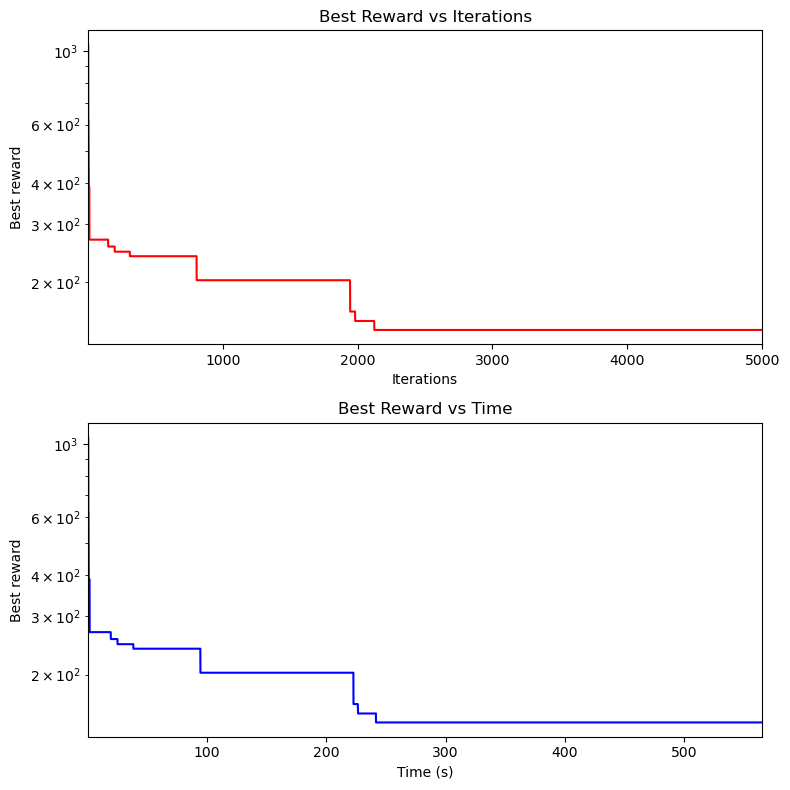

In [42]:
#plot_training(data_res, e_tot)
performance_plots(e_tot, time_axis, gbest_history, multiruns=False)

In [331]:
# Stability analysis

def reward_stability(algorithm, no_runs, no_bin, iterations):
    rewards = []
    times = []
    gbests = np.zeros((iterations+1, no_runs))
    time_matrix = np.zeros((iterations+1,))
    
    for i in range(no_runs):
        if algorithm == ArtificialBeeColony:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=round(25), iterations=iterations, distance_value=1, scout_limit=2)
        elif algorithm == ParticleSwarm:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_particles=round(50), inertia=0.6, cognitive=0.2, social=0.2, regime=None, tmax=iterations)
        elif algorithm == GeneticSearch:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, mutation_rate=0.35, iterations=iterations, sample_size=55)
        elif algorithm == Firefly:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_fireflies=round(10), iterations=iterations, attractiveness=0.8, absorption=0, randomness=0.2)
        elif algorithm == SimulatedAnnealing:
            best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, initial_accept_prob=0.4, max_iterations=iterations+1, step_size=0.4, temp_regime='log')
        else:
            print("Invalid algorithm")
        gbest_time = time_axis[gbest_history.index(best_reward)]
        rewards.append(best_reward)
        times.append(gbest_time)
        gbests[:, i] = np.array(gbest_history)
        # print(time_axis)
        time_matrix = np.array(time_axis)
        
    # Plot a histogram of the rewards with the mean and standard deviation
    plt.hist(rewards, bins = no_bin, edgecolor = 'black')
    performance_plots(50, time_matrix, gbests, multiruns=True)
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.title('Stability of the reward')
    plt.show()
        
    
    return rewards, times

In [332]:
stability = reward_stability(algorithm= ParticleSwarm, no_runs = 10, no_bin = 20, iterations=50)

Iteration 0
Iteration 1
Iteration 2
Iteration 3


KeyboardInterrupt: 

In [ ]:
# hyperparameter tuning - with skopt
# Work in progress!
pso_space = {"no_particles": Integer(1,100), "inertia": Real(0,1), "cognitive": Real(0,1), "social": Real(0,1), "tmax": Integer(1,100)}

def pso_algorithm():
    best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-5, upper_bound=5, no_particles=50, inertia=0.6, cognitive=0.04, social=0.36, tmax=50)
    return best_reward

opt = BayesSearchCV(pso_algorithm, pso_space, optimizer_kwargs={'base_estimator': 'GP'}, n_iter=10, random_state=42)
optimizer.fit(None)
best_params = optimizer.best_params_
print("Best Parameters:", best_params)





NameError: name 'Integer' is not defined

In [ ]:
def hpp_search(lower1, upper1, num1, lower2, upper2, num2, algorithm):
    best_rewards = {'coordinates': [], 'values': []}
    times_taken = {'coordinates': [], 'values':[]}
    var1_range = np.linspace(lower1, upper1, num=num1)
    var2_range = np.linspace(lower2, upper2, num=num2)
    var1_coords = []
    var2_coords = []
    
    # var1 = ratio of onlooker to employed
    # var2 = scout limit

    for v1 in var1_range:
        for v2 in var2_range:
            if algorithm == ArtificialBeeColony:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_employed=25, no_onlooker=round(25*v1), iterations=50, distance_value=1, scout_limit=v2) 
            elif algorithm == ParticleSwarm:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_particles=round(v1), inertia=v2, cognitive=0.04, social=0.36, tmax=50)
            elif algorithm == GeneticSearch:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, mutation_rate=v1, iterations=50, sample_size=v2)
            elif algorithm == Firefly:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, no_fireflies=round(v1), iterations=50, attractiveness=0.8, absorption=0, randomness=0.2)
            elif algorithm == SimulatedAnnealing:
                best_policy, best_reward, gbest_history, time_axis = algorithm(lower_bound=-5, upper_bound=5, initial_accept_prob=v1, max_iterations=500, step_size=v2, temp_regime='log')
            else:
                print("Invalid algorithm")
            gbest_time = time_axis[gbest_history.index(best_reward)]
            time_taken = time_axis[-1]
            best_rewards['coordinates'].append((v1, v2))
            times_taken['coordinates'].append((v1, v2))
            best_rewards['values'].append(best_reward)
            times_taken['values'].append(gbest_time)
            var1_coords.append(v1)
            var2_coords.append(v2)

    var1_coords = np.array(var1_coords)
    var2_coords = np.array(var2_coords)
       
    np_times = np.array(times_taken['values'])
    np_rewards = np.array(best_rewards['values'])

    shortest_time = np_times.argmin()
    lowest_reward = np_rewards.argmin()

    shortest_hpp = {'mutation rate': times_taken['coordinates'][shortest_time][0], 'sample size': times_taken['coordinates'][shortest_time][1]}
    best_hpp = {'mutation rate': best_rewards['coordinates'][lowest_reward][0], 'sample_size': best_rewards['coordinates'][lowest_reward][1]}

    time_efficiencies = np_times * np_rewards
    most_efficient = time_efficiencies.argmin()

    efficient_hpp = {'mutation rate': times_taken['coordinates'][most_efficient][0], 'sample size': times_taken['coordinates'][shortest_time][1]}

    max_time = np.max(np_times)
    min_time = np.min(np_times)
    max_reward = np.max(np_rewards)
    min_reward = np.min(np_rewards)

    X = (np_times - min_time) / (max_time - min_time)
    Y = (np_rewards - min_reward) / (max_reward - min_reward)
    # X, Y = np.meshgrid(X,Y)
    Z = (X+1) * (Y+1) - 1
    print(shortest_hpp)
    print(best_hpp)
    print(efficient_hpp)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot in 3D with vmin and vmax
    scatter = ax.scatter(var1_coords, var2_coords, Z, cmap=cm.coolwarm, vmin=np.min(Z), vmax=np.max(Z))

    # Set the limits for the Z-axis
    ax.set_zlim(-1, 4)

    # Configure tick locators for the Z-axis
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors
    colorbar = fig.colorbar(scatter, shrink=0.5, aspect=5)

    colorbar.set_label('Time efficiencies')

    # Set labels for the axes
    ax.set_xlabel('Mutation Rates')
    ax.set_ylabel('Sample Sizes')
    ax.set_zlabel('Time efficiencies')

    plt.show()
    
    return shortest_hpp, best_hpp, efficient_hpp




Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_22398/3348308178.py:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scatter = ax.scatter(var1_coords, var2_coords, Z, cmap=cm.coolwarm, vmin=np.min(Z), vmax=np.max(Z))


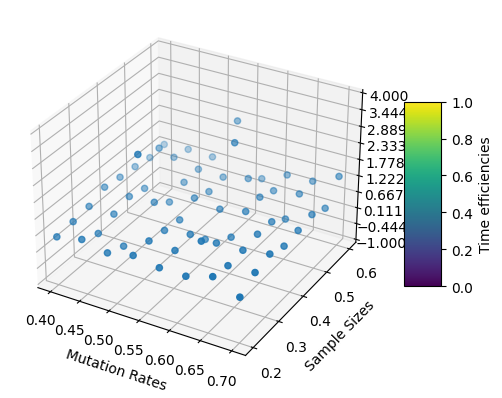

In [ ]:
#bestbestreward = best_rewards['values'][lowest_reward]
#print(best_rewards['coordinates'])
#print(best_rewards['values'])
#print(times_taken['values'])
shortest_hpp, best_hpp, efficient_hpp = hpp_search(lower1=0.4, upper1=0.7, num1=8, lower2=0.2, upper2=0.6, num2=8, algorithm=SimulatedAnnealing)

Notice that the 'input size' below has an extra +2. This is because we must pass the information to the policy network about the setpoint (given that our setpoint will change). Therefore, we give 2 extra inputs to our policy network, one for each setpoint.

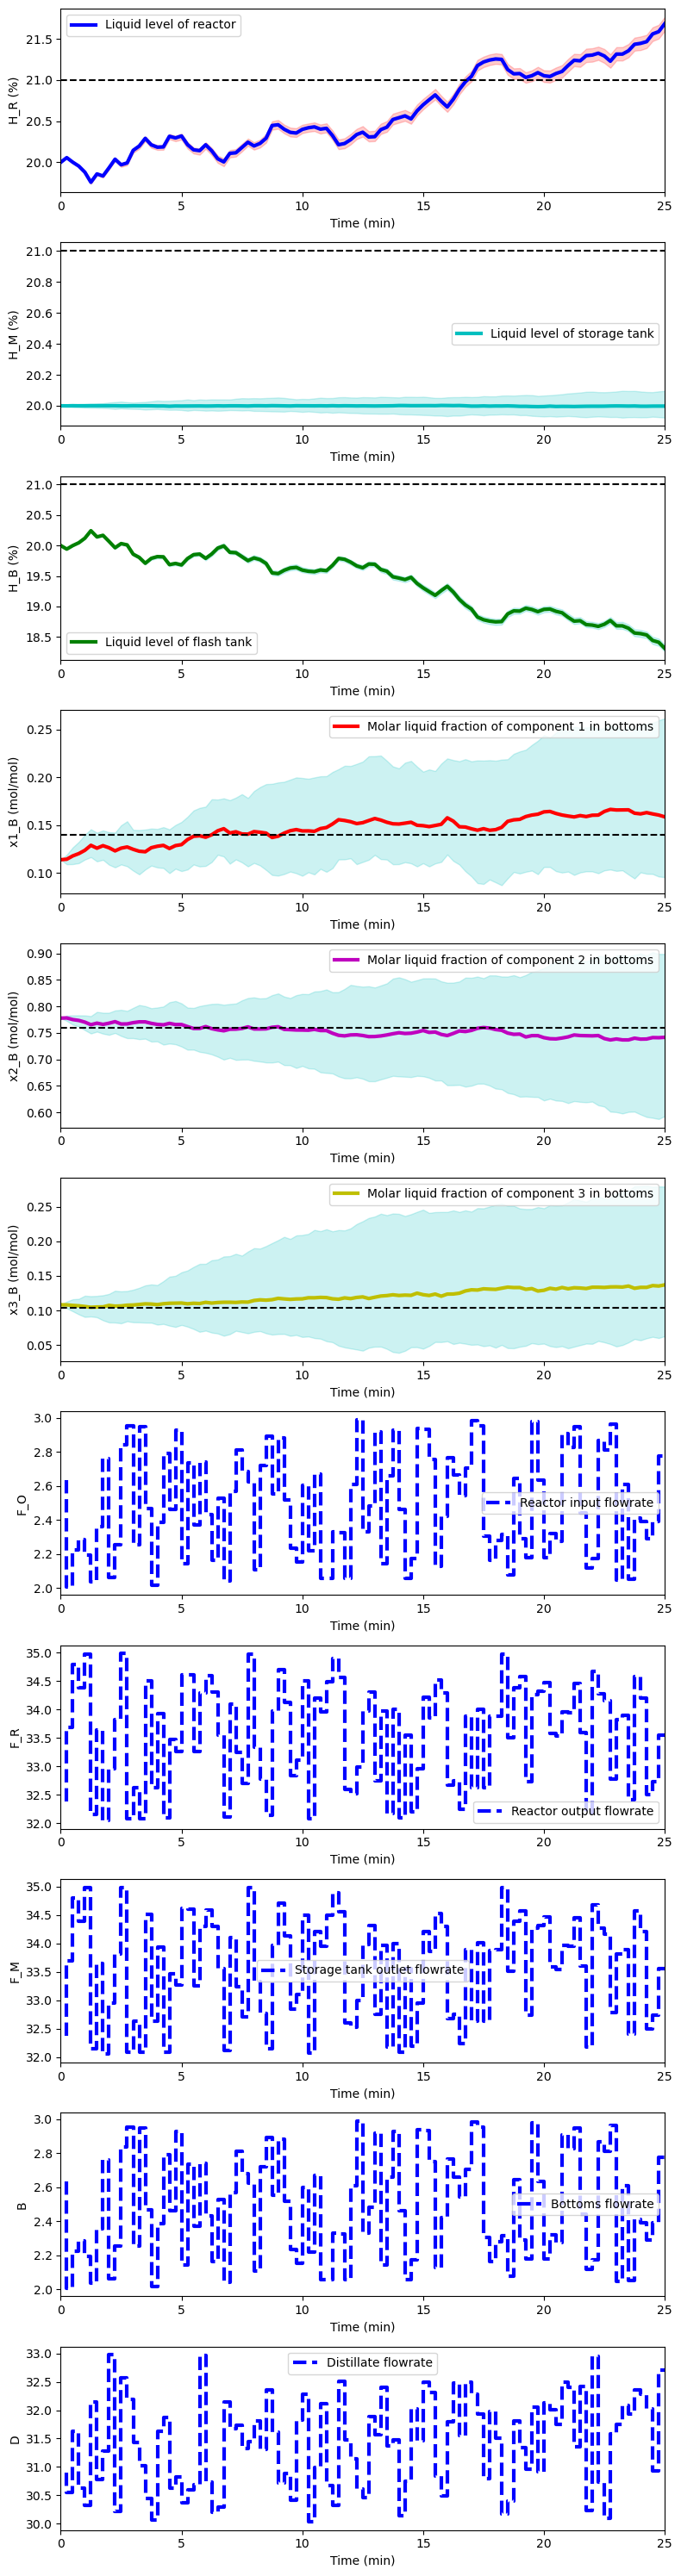

In [47]:
nx            = 6
nu            = 5
hyparams      = {'input_size': nx+6, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy)

reps = 10

H_R_eval = np.zeros((data_res['H_R_dat'].shape[0], reps))
H_M_eval = np.zeros((data_res['H_M_dat'].shape[0], reps))
H_B_eval = np.zeros((data_res['H_B_dat'].shape[0], reps))
x1_B_eval = np.zeros((data_res['x1_B_dat'].shape[0], reps))
x2_B_eval = np.zeros((data_res['x2_B_dat'].shape[0], reps))
x3_B_eval = np.zeros((data_res['x3_B_dat'].shape[0], reps))


F_O_eval = np.zeros((data_res['F_O_dat'].shape[0], reps))
F_R_eval = np.zeros((data_res['F_R_dat'].shape[0], reps))
F_M_eval = np.zeros((data_res['F_M_dat'].shape[0], reps))
B_eval = np.zeros((data_res['B_dat'].shape[0], reps))
D_eval = np.zeros((data_res['D_dat'].shape[0], reps))

for r_i in range(reps):
  H_R_eval[:,r_i], H_M_eval[:,r_i], H_B_eval[:,r_i], x1_B_eval[:,r_i], x2_B_eval[:,r_i], x3_B_eval[:,r_i], F_O_eval[:,r_i], F_R_eval[:,r_i], F_M_eval[:,r_i], B_eval[:,r_i], D_eval[:,r_i] = J_PolicyPLANT(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True) 

# , X1_eval[:,r_i], X2_eval[:,r_i], X3_eval[:,r_i], X4_eval[:,r_i], Y2_eval[:,r_i], Y3_eval[:,r_i], Y4_eval[:,r_i], Y5_eval[:,r_i]
  
# Plot the results
plot_simulation(H_R_dat, H_M_dat, H_B_dat, x1_B_dat, x2_B_dat, x3_B_dat, data_res)

# X1_eval, X2_eval, X3_eval, X4_eval, Y2_eval, Y3_eval, Y4_eval, Y5_eval,

### Remarks on stochastic policy search

As it can be observed from the simple example above Stochastic local search methods work well in practice and are much easier to implement that other techniques (such as policy gradients). In general, as we move to large parameter spaces, for example neural networks with millions of parameters, their performance will deteriorate, and a policy gradient-like approach will be more desireable. 

## Policy Gradients 🗻

Policy gradient methods rely on the [Policy Gradient Theorem](https://link.springer.com/article/10.1007/BF00992696) which allows to retrieve the gradient of the expected objective function with respect to policy parameters (neural network weights) $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ through Monte Carlo runs. Given the availability of gradients, it is possible to follow a gradient-based optimization to optimize the policy, generally, Adam or Gradient Descent is used. More information can be found of Chapter 13 on [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html). 

In this tutorial notebook we outline the simplest algorithm of this kind, **Reinforce**. For a more in dept introduction to the topic see [Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

In the case of stochastic policies, the policy function returns the defining parameters of a probability distribution (such as the mean and variance) over possible actions, from which the actions are sampled: 
$$\textbf{u} \sim \pi_\theta(\textbf{u} | \textbf{x}) = \pi(\textbf{u} | \textbf{x}, \theta) = p(\textbf{u} | \textbf{x}, \theta)$$

Note*: this is the same as the stochastic policy introduced earlier, following the 'probability notation'.

To learn the optimal policy, we seek to maximize our performance metric, and hence we can follow a gradient ascent strategy: 
$$\theta_{m+1} = \theta_m + \alpha_m \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] $$

where $m$ is the current iteration that the parameters are updated (epoch), $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ is the expectation of $f$ over $\pi_\theta$ and $\alpha_m$ is the step size (also termed learning rate in the RL community) for the $m^{th}$ iteration. 

Computing $ \nabla_\theta \hat{f}(\theta) = \nabla_\theta\mathbb{E}_{\pi_\theta}[J(\pi_\theta)]$ directly is difficult, therefore we use the Policy Gradient Theorem, which shows the following:


$$ \begin{alignat}{3}
\nabla_\theta\hat{f}(\theta) = \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] &~=~\nabla_\theta \int  p(\pi_\theta|\theta)~ f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\int \nabla_\theta p(\pi_\theta|\theta)~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \frac{\nabla_\theta p(\pi_\theta|\theta)}{p(\pi_\theta|\theta)~} ~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right]
\end{alignat} $$

Notice from the first expression, that, $p(\pi_\theta|\theta)~ f(\pi_\theta)$ is an objective function value multiplied by its probability density, therefore, integrating this over all possible values of $\pi_\theta$ we obtain the expected value. From there, using simple algebra, logarithms and the chain rule, we arrive at the final equations, which shows an expected value, where, dropping the explicit distribution of $\pi_\theta$, gives us an unbiased gradient estimator, our steepest ascent update now becomes:

$$ \theta_{m+1} = \theta_m + \alpha_m \mathbb{E}_{\pi_\theta}\left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right] 
$$

Using the expression for $p(\pi_\theta|\theta) = \hat{\mu}(\textbf{x}_0) \prod_{t=0}^{T-1} \left[\pi(\textbf{u}_t|\textbf{x}_t,\theta) p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t) \right]$ and taking its logarithm, we obtain:

$$\nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) = \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)$$

Note that since $p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t)$ and $\hat{\mu}(\textbf{x}_0)$ are independent of $\theta$ they disappear from the above expression. Then we can rewrite for a trajectory as:

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] = \mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right]$$

The above expression does not require the knowledge of the dynamics of the physical system. Monte-Carlo method is utilized to approximate the expectation.

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} \left( f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right)$$


**Reinforce algorithm**

${\bf Input:}$ Initialize policy parameter $\theta = \theta_0$, with $\theta_0\in\Theta_0$, learning rate $\alpha$, set number of episodes $K$ and number of epochs $N$.

${\bf Output:}$ policy $\pi(\cdot | \cdot ,\theta)$ and $\Theta$
\smallskip

${\bf for}$ $m = 1,\dots, N$ ${\bf do}$


1.   Collect $\textbf{u}_t^k , \textbf{x}_t^k,f(\pi_\theta^k)$ for $K$ trajectories of $T$ time steps.
2.   Estimate the gradient $ \hat{g}_m := \frac{1}{K} \sum_{k=1}^{K}  \left[ f(\pi_\theta^k) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t^k|\hat{\textbf{x}}_t^k,\theta)\right)\right]$
3.   Update the policy using a policy gradient estimate $\theta_{m+1} = \theta_m + \alpha_m \hat{g}_m$
4.   $m:=m+1$

${\bf Remark}$: The above algorithm is the base version for many further developments that have been made since it was first proposed. 

The steps of the algorithm are explained below:

${\bf Initialization:}$ The policy network and its weights $\theta$ are initialized along with the algorithm's hyperparameters such as learning rate, number of episodes and number of epochs.

${\bf Training ~~ loop:}$ The weights of the policy network are updated by a policy gradient scheme for a total of $N$ epochs. 

In ${\bf Step 1}$ $K$ trajectories are computed, each trajectory consists of $T$ time steps, and states and control actions are collected. 

In ${\bf Step 2}$ the gradient of the objective function with respect to the weights for the policy network is computed. 

In ${\bf Step 3}$ the weights of the policy network are updated by a gradient ascent scheme. Note that here we show a steepest ascent-like update, but other first order (i.e. Adam) or trust region methods can be used (i.e. PPO, TRPO). 

In ${\bf Step 4}$, either the algorithm terminates or returns to Step 1.

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.distributions import MultivariateNormal

In order to implement and apply the Reinforce algorithm, we are going to perform the following steps in the following subsections:


*   Create a [policy network](#policy_net) that uses transfer learning
*   Create an auxiliary function that selects [control actions](#control_actions) out of the distribution
*   Create an auxilary function that runs [multiple episodes](#multi_episodes) per epoch
*   Finally, put all the pieces together into a function that computes the [Reinforce algorithm](#r_alg)



<a name="policy_net"></a>
### Policy network


In the next section of this tutorial notebook we show an implementation from scratch of a policy optimization algorithm using policy gradients.

Given that we have already optimized the policy via stochastic search in the previous section, we use those parameters as a starting point for policy gradients. This is a form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning#:~:text=Transfer%20learning%20(TL)%20is%20a,when%20trying%20to%20recognize%20trucks.), which refers to applying knowledge that was previously gained while solving one task to a related task. 

Related to this transfer learning process, we will create a second neural network with the exact same configuration as before, but we will add an extra node to each output of the original neural network to account for the variance term. This is because previously our neural network policy had the structure:

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and by a Stochastic search algorithm we manipulated the weights $\boldsymbol{\theta}$ to optimize performance. In policy gradients we output a distribution, rathen than a single value, in this case we output the mean and the variance of a normal distribution (each output now has two values, the mean and the variance), and therefore we must add an extra node to each output such that we have:

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := \pi({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$



In [ ]:
#########################################
# Policy Network with transfer learning #
#########################################

class Net_TL(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net_TL, self).__init__()

    self.dtype    = torch.float

    # Unpack the dictionary 
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available() 
    self.device   = torch.device("cpu")

    # Define ANN topology 
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2 

    # Define layers 
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def forward(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = x.view(1, 1, -1).float()
    y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
    y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
    y = Ffunctional.relu6(self.output(y))   # range (0,6)

    return y

  def increaseClassifier(self, m:torch.nn.Linear):
    w         = m.weight
    b         = m.bias
    old_shape = m.weight.shape

    m2        = nn.Linear( old_shape[1], old_shape[0] + 1)
    m2.weight = nn.parameter.Parameter( torch.cat( (m.weight, m2.weight[0:1]) ), 
                                       requires_grad=True )
    m2.bias   = nn.parameter.Parameter( torch.cat( (m.bias, m2.bias[0:1]) ), 
                                       requires_grad=True)
    return m2
  
  def incrHere(self): 
    self.output = self.increaseClassifier(self.output)

Notice that just as before, we ad a +2 to the input, as thisrefers to the current set-point value.

In [ ]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2

policy_net_pg = Net_TL(**hyparams, requires_grad=True, retain_graph=True)
policy_net_pg.load_state_dict(best_policy) # Transfer learning
policy_net_pg.incrHere()

RuntimeError: Error(s) in loading state_dict for Net_TL:
	Unexpected key(s) in state_dict: "hidden3.weight", "hidden3.bias". 
	size mismatch for hidden1.weight: copying a param with shape torch.Size([24, 12]) from checkpoint, the shape in current model is torch.Size([8, 4]).
	size mismatch for hidden1.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for hidden2.weight: copying a param with shape torch.Size([24, 24]) from checkpoint, the shape in current model is torch.Size([2, 8]).
	size mismatch for hidden2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([2]).
	size mismatch for output.weight: copying a param with shape torch.Size([2, 4]) from checkpoint, the shape in current model is torch.Size([1, 2]).
	size mismatch for output.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

<a name="control_actions"></a>
### Control action selection


In [ ]:
################################
# action selection from Normal #
################################

def select_action(control_mean, control_sigma):
    """
    Sample control actions from the distribution their distribution
    input: Mean, Variance
    Output: Controls, log_probability, entropy
    """
    s_cov          = control_sigma.diag()**2
    dist           = MultivariateNormal(control_mean, s_cov)
    control_choice = dist.sample()                 # sample control from N(mu,std)
    log_prob       = dist.log_prob(control_choice) # compute log prob of this action (how likely or unlikely)
    entropy        = dist.entropy()                # compute the entropy of the distribution N(mu, std)
    
    return control_choice, log_prob, entropy

#########################
# un-normalizing action #
#########################

def mean_std(m, s, mean_range=[10], mean_lb=[295], std_range=[0.001]):
    '''
    Problem specific restrictions on predicted mean and standard deviation.
    '''
    mean = Tensor(mean_range) * m/6 + Tensor(mean_lb) # ReLU6
    std  = Tensor(std_range)  * s/6
    
    return mean, std

<a name="multi_episodes"></a>
### Multiple episodes - one epoc/training step


In [ ]:
################
# one epoc run #
################

def epoc_run(NNpolicy, episodes_n):
    '''This function runs episodes_n episodes and collected the data. This data
    is then used for one gradient descent step.

    INPUTS
    NNpolicy:   the NN policy
    episodes_n: number of episodes per epoc (gradient descent steps)
    data_train: dictionary of data collected

    OUTPUTS
    data_train: collected data to be passed to the main training loop
    '''

    # run episodes
    logprobs_list = [] # log probabilities is the policies itself p(a|s)
    reward_list   = [] # reward
    for epi_i in range(episodes_n):
        reward_, sum_logprob = J_PolicyCSTR(NNpolicy, policy_alg='PG_RL', 
                                            collect_training_data=True, episode=True)
        logprobs_list.append(sum_logprob)
        reward_list.append(reward_)

    # compute mean and expectation of rewards
    reward_m   = np.mean(reward_list)
    reward_std = np.std(reward_list)
    

    # compute the baseline (reverse sum)
    log_prob_R = 0.0
    for epi_i in reversed(range(episodes_n)):
        baselined_reward = (reward_list[epi_i] - reward_m) / (reward_std + eps)
        log_prob_R       = log_prob_R - logprobs_list[epi_i] * baselined_reward

    # mean log probability
    mean_logprob = log_prob_R/episodes_n
    reward_std   = reward_std
    reward_m     = reward_m

    return mean_logprob, reward_std, reward_m 

<a name="r_alg"></a>
### Reinforce algorithm

Now, let's create a function that put all pieces together and implements the Reinforce algorithm explained above

In [ ]:
def Reinforce(policy, optimizer, n_epochs, n_episodes):

    # lists for plots
    rewards_m_record = []; rewards_std_record = []

    for epoch_i in range(n_epochs):

        # collect data
        mean_logprob, reward_std, reward_m = epoc_run(policy, n_episodes)

        # Expected log reward 
        E_log_R = mean_logprob
        optimizer.zero_grad()
        E_log_R.backward()
        optimizer.step()

        # save data for analysis
        rewards_m_record.append(reward_m)
        rewards_std_record.append(reward_std)

        # schedule to reduce lr
        scheduler.step(E_log_R)

        if epoch_i%int(n_epochs/10)==0:
            mean_r = reward_m
            std_r  = reward_std
            print('epoch:', epoch_i)
            print(f'mean reward: {mean_r:.3} +- {std_r:.2}')

    return rewards_m_record, rewards_std_record, policy

### Apply the Reinforce algorithm

Now that we have the algorithm, let's apply it to the problem. 

Let's choose some problem parameters and initialize storing lists

In [ ]:
# problem parameters
lr         = 0.0001
total_it   = 2000
n_episodes = 50
n_epochs   = int(total_it/n_episodes)

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

define the policy and the optimizer to be used

In [ ]:
# define policy and optimizer
control_policy = policy_net_pg
optimizer_pol  = optim.Adam(control_policy.parameters(), lr=lr)

define the learning rate scheduler

In [ ]:
# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pol, factor=0.5, patience=10, verbose=True, min_lr=0.000001,
    cooldown = 10)

and apply the algorithm

```{note} Runing the algorithm will last for a few minutes
```

In [ ]:
rewards_m_record, rewards_std_record, optimal_Reinforce = \
Reinforce(control_policy, optimizer_pol, n_epochs, n_episodes)

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_18911/3967602739.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tc[i]                     = u_k


epoch: 0
mean reward: -23.7 +- 0.82
epoch: 4
mean reward: -23.5 +- 0.69
epoch: 8
mean reward: -23.7 +- 0.77
epoch: 12
mean reward: -23.9 +- 0.82
epoch: 16
mean reward: -23.9 +- 0.92
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
epoch: 20
mean reward: -23.6 +- 1.1
epoch: 24
mean reward: -23.5 +- 0.95
epoch: 28
mean reward: -23.6 +- 0.98
epoch: 32
mean reward: -23.4 +- 0.89
epoch: 36
mean reward: -23.4 +- 0.86
Epoch 00040: reducing learning rate of group 0 to 2.5000e-05.


Let's visualize now

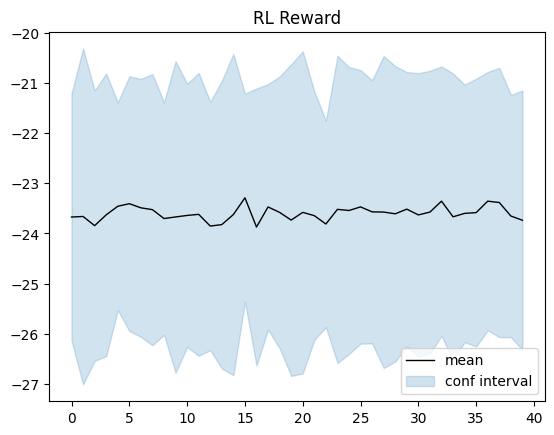

In [ ]:
# plot the samples of posteriors
plt.plot(rewards_m_record, 'black', linewidth=1)
# plot GP confidence intervals
iterations = [i for i in range(len(rewards_m_record))]
plt.gca().fill_between(iterations, np.array(rewards_m_record) - 3*np.array(rewards_std_record), 
                       np.array(rewards_m_record) + 3*np.array(rewards_std_record), 
                       color='C0', alpha=0.2)
plt.title('RL Reward')
plt.legend(('mean', 'conf interval'),
           loc='lower right')
plt.show()

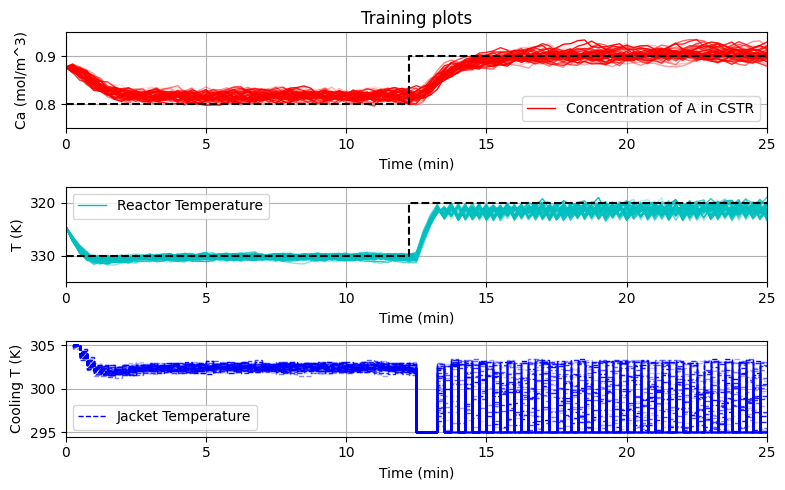

In [ ]:
plot_training(data_res, e_tot)

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_18911/3967602739.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tc[i]                     = u_k


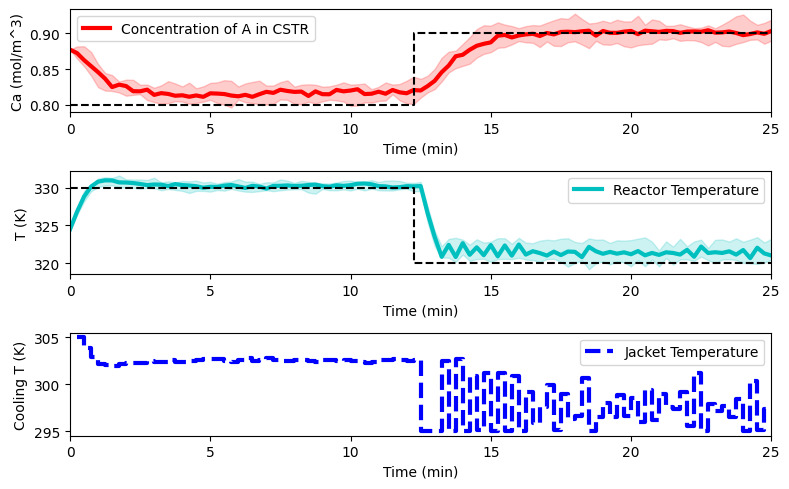

In [ ]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_pg,
                                                               policy_alg='PG_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

## Extra material on RL for ChemEng 🤓

If you would like to read more about the use of reinforcement learning in chemical engineering systems:

**Applications** 

*   Reinforcement learning offers potential for bringing significant improvements to [industrial batch process control practice](https://www.sciencedirect.com/science/article/abs/pii/S136757882100081X) even in [discontinous and nonlinear systems](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168).
*   RL has also been used to address [chemical production scheduling](https://www.sciencedirect.com/science/article/pii/S0098135420301599) and [multi-echelon supply chains](https://www.sciencedirect.com/science/article/pii/S2772508122000643)
*   Other applications include [PID tuning](https://www.sciencedirect.com/science/article/abs/pii/S0967066121002963), [real-time optimization](https://www.mdpi.com/2227-9717/11/1/123), [searching for optimal process routes](https://www.sciencedirect.com/science/article/abs/pii/S0098135420303999), [flowsheet generation](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17938), [bioreactors](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168) and [biotherapeutics](https://onlinelibrary.wiley.com/doi/10.1002/bit.28346), amongst many others.

**Methodologies** 

*   Constraints to address [plant-model mismatch](https://www.sciencedirect.com/science/article/abs/pii/S0098135421004087), [constrained Q-learning](https://www.sciencedirect.com/science/article/abs/pii/S0098135421002404), [safe reinforcement learning](https://www.researchgate.net/publication/368302457_Safe_deployment_of_reinforcement_learning_using_deterministic_optimization_of_trained_neural_networks), satisfaction of constraints with [high probability](https://www.sciencedirect.com/science/article/pii/S0959152422000038), and [dynamic penalties](https://www.sciencedirect.com/science/article/pii/S0959152422000816) for better convergence.
*   [Process control](https://www.mdpi.com/2227-9717/10/11/2311), [meta-reinforcement learning](https://www.sciencedirect.com/science/article/pii/S0959152422001445), [general economic process control](https://www.sciencedirect.com/science/article/pii/S0098135420307912), amongst many many others. 

 